# Dark bias data prep

### Imports

In [1]:
import logging
import os
from importlib import reload

#std libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#custom libraries
from bric_analysis_libraries import standard_functions as std
from bric_analysis_libraries.jv import ec_lab_data_prep as ecdp
from bric_analysis_libraries.jv import biologic_data_prep as bldp
from bric_analysis_libraries.jv import jv_analysis as jva

In [ ]:
logging.basicConfig (level = logging.WARNING)
# reload (bldp)

In [2]:
def import_mpp (
    folder, 
    file_name = 'mpp.csv',
    skiprows = 1
):
    '''
    Imports MPP data
    :param folder: Data path.
    :param file_name: File name. [Default = mpp.csv]
    :param skiprows: Number of rows to skip. [Default = 0]
    :returns: A Pandas DataFrame indexed by channel.
    '''
    logging.info ('Importing data.')
    
    path = os.path.join (folder, file_name)
    
    # importing data
    df = pd.read_csv (path, header = [0, 1], skiprows = range (2, 2 + skiprows))
    logging.info ('Data imported from "{}".'.format (path))

    # removing the Cycle column
    df = df.drop ('Cycle', axis = 1, level = 1)

    # changing the columns' names to 'time', 'voltage', 'current' and 'power'
    channels = [int (a) for a in df.columns.get_level_values (0).unique ()]

    metric = ['time', 'voltage', 'current', 'power']
    if 'Lamp' in df.columns.get_level_values (1):
        metric = ['time', 'voltage', 'current', 'power', 'lamp']
    df.columns = pd.MultiIndex.from_product ([channels, metric], names = ['channel', 'parameter'])
    
    df = df.stack ('channel').droplevel (0).sort_values (['channel', 'time'])
    
    # changing the sign of the 'power' column
    df ['power'] = - df ['power']
    
    return df

def import_mpps (
    folder,
    file_format = 'mpp-<>',
    skiprows = 1
):
    '''
    Imports MPP data for a series of measurement with varied hold voltage.
    :param folder: Data path.
    :param file_format: File format, the experiment number is substituted
    by <>.  [Default = mpp-<>]
    :param skiprows: Number of rows to skip. [Default = 1]
    :returns: A Pandas DataFrame indexed by experiment and channel.
    '''
    files = os.listdir (folder)
    dfs = []
    
    for file in files:
        df = import_mpp (
            folder = folder,
            file_name = file,
            skiprows = skiprows,
        )
        ms = std.metadata_from_file_name (
            file_format,
            os.path.join (folder, file),
            is_numeric = True
        )
        std.insert_index_levels (
            df,
            int (ms),
            names = 'measurement',
            axis = 0,
            inplace = True
        )
        dfs.append (df)
        
    dfs = pd.concat (dfs)
    return dfs

def add_hold_voltage (
    df,
    folder,
    file_name = 'hold_voltage.pkl'
):
    '''
    :param df: A Pandas dataframe indexed by measurement and channel.
    :param folder: Data path.
    :param file_name: Name of the .pkl file containing the voltage information. 
    [Default = 'hold_voltage.pkl'] 
    :returns: A Pandas dataframe with "hold_voltage" as an additional index level.
    '''
    logging.info ('Adding hold voltage.')
    hv = pd.read_pickle (os.path.join (folder, file_name))
    df ['hold_voltage'] = hv.stack ().reorder_levels (['measurement', 'channel'])
    return df.set_index ('hold_voltage', append = True)

In [ ]:
# def assign_cycles (
#     df, 
#     mpl = 4
# ):
#     '''
#     Assigns a cycle index to a dataframe by comparing the difference between two adjoining
#     current values and the standard deviation of the difference.
#     :param df: A pandas DataFrame.
#     :param mpl: A factor to multiply the standard deviation with. [Default = 4] 
#     :returns: A Pandas DataFrame with assigned cycles. 
#     '''
    
#     logging.info ('Appending cycle count.')
    
#     # calculating the difference and the threshold value
#     diff = df ['current'].rolling (8).median ().diff ().abs ()
#     thresh = mpl * diff.std ()

#     cycle = []
#     cy = 0
#     n = 0

#     while n < len (diff):
#         # an odd cycle starts as soon as the difference
#         # crosses the threshold value
#         if abs (diff.iloc [n]) > thresh and cy % 2 is 0 and abs (diff.iloc [n - 1]) < thresh:
#             cy += 1
#             cycle.append (cy)

#             # skipping the next 10 values to avoid double counting
#             a = n + 10
#             while n < a:
#                 n += 1
#                 if n < len (diff):
#                     cycle.append (cy)

#         # an even cycle starts only with the last value in a 
#         # group of values crossing the threshold
#         elif abs (diff.iloc [n]) > thresh and cy % 2 is not 0 and abs (diff.iloc [n + 1]) < thresh:
#             cy += 1
#             cycle.append (cy)

#             # skipping the next 10 values to avoid double counting
#             a = n + 10
#             while n < a:
#                 n += 1
#                 if n < len (diff):
#                     cycle.append (cy)

#         else:
#             cycle.append (cy)
#         n += 1
    
#     # appending the cycle count to the dataframe
#     df = df.copy ()
#     df ['cycle'] = cycle
#     df = df.set_index ('cycle', append = True)
#     logging.info ('Cycle count appended.')

#     return df

In [1]:
def assign_cycles (
    df,
    mpl = 0.01,
    bins = 10, 
    window = 31
):
    '''
    Assigns a cycle column to a DataFrame.
    :param df: A pandas DataFrame.
    :param mpl: A factor to multiply the maximum value of counts to
    obtain the cutoff value. [Default: 0.01] 
    :param bins: Number of divisions in the histogram. [Default: 10]
    :param window: Size of window for function rolling ().median (),
    applied to 'light' column. Must be an odd natural number. [Default: 31]
    :returns: A Pandas DataFrame with cycle column. 
    '''
    
    logging.info ('Appending cycle count.')
    df = df.copy ()
    
    if 'lamp' not in df.columns.get_level_values ('parameter'):
        (density, ranges) = np.histogram (df ['power'].rolling (8).median ().dropna(), bins = 10)

        cutoff = mpl * density.max ()


        # threshold value taken after the lower max is reached, 
        # when density is lower than the cutoff value (0 if no value determined)
        threshold = 0
        was_bigger = False
        for (n, d) in enumerate (density):
            if was_bigger == True and d < cutoff:
                threshold = ranges [n]
                break
            elif d > cutoff and was_bigger == False:
                was_bigger = True


        # light == 1 if power above threshold value
        df ['lamp'] = np.where (df ['power'] > threshold, 1, 0)
        df ['lamp'] = df ['lamp'].rolling (window, min_periods = 1, center = True).median ()

    # increase the cycle count when the light switches
    cycles = []
    cycle = 0
    last_light = 1
    for light in df ['lamp'].dropna ():
        if light != last_light:
            cycle += 1
        cycles.append (cycle)
        last_light = light
    df ['cycle'] = cycles
    df = df.drop (columns = 'lamp')
    df = df.set_index ('cycle', append = True)
    
    return df
    
    
def remove_odd_cycles (df):
    '''
    Removes data for odd cycles.
    :param df: A Pandas DataFrame indexed by cycles.
    :returns: A Pandas DataFrame without data for odd cycles.
    '''
    
    logging.info  ('Removing odd cycles')
    rdf = []
    cygb = df.groupby ('cycle')
    for cy, data in cygb:
        if cy % 2 is 0:
            rdf.append (data)
    
    logging.info ('Odd cycles removed.')
        
    return pd.concat (rdf)

In [4]:
def relative_time (df):
    '''
    Calculates the time since a cycle started.
    :param df: A Pandas DataFrame.
    :returns: A Pandas DataFrame with an additional column 'r_time'.
    '''
    
    logging.info ('Calculating relative time.')
    dfc = df.copy ()
    dfc ['r_time'] = df.groupby ('cycle') ['time'].transform (lambda x: x - x.iloc [0])
    
    return dfc


def fit_exp (df):
    '''
    Fits an exponential function to the data.
    :param df: A Pandas DataFrame indexed by relative time.
    :returns: A Pandas DataFrame of the fit parameters and std deviation
    '''
    
    exp = lambda x, A0, t1, P0: (
        A0 * np.exp (-x/t1) + P0
    )
    
    # defining the guess parameters
    def guess (data): 
        P0 = data.iloc [-9 : -1].median ()
        A0 = data.iloc [1 : 9].median () - P0
        t1 = 120
        return A0, t1, P0
    
    fit = std.df_fit_function (exp, guess = guess) 
    df_smooth = df.rolling (8).median ()
    return fit (df_smooth)

def fit_lin_exp (df, **kwargs):
    '''
    Fits an exponential function to the data.
    :param df: A Pandas DataFrame indexed by relative time.
    :param kwargs: Additional arguments passed to std.df_fit_function.
    :returns: A Pandas DataFrame of the fit parameters and std deviation
    '''
    
    exp = lambda x, A, t, B, C: (
        - A * np.exp (-x/t) + B * x + C
    )
    
    # defining the guess parameters
    def guess (data): 
        # define the slices so they can be changed more easily
        dy = data.iloc [-9 : -1].mean () - data.iloc [-909 : -901].mean ()
        dx = data.index.values [-9 : -1].mean () - data.index.values [-909 : -901].mean ()
        B = dy / dx
        C = data.iloc [-9 : -1].median () - B * data.index.values [-9 : -1].mean ()
        A = C - data.iloc [1 : 5].median ()
        t = 10
#         print (f'Guess: A = {A:.2E},\t t = {t:.2E},\t B = {B:.2E},\t C = {C:.2E}\t')
        return A, t, B, C
    
    fit = std.df_fit_function (exp, guess = guess, **kwargs) 
    return fit (df)


def fit_d_exp (df, **kwargs):
    '''
    Fits an exponential function to the data.
    :param df: A Pandas DataFrame indexed by relative time.
    :param kwargs: Additional arguments passed to std.df_fit_function.
    :returns: A Pandas DataFrame of the fit parameters and std deviation
    '''
    
    exp = lambda t, P0, P1, P2, tau1, tau2: (
        P0 + P1 * (1 - np.exp (-t/tau1)) + P2 * (1 - np.exp (-t/tau2))
    )
    
    # defining the guess parameters
    def guess (data): 
        # define init, mid, and end point for P guesses
        p_i = data.iloc [1 : 4].mean ()
        p_m = data.iloc [50 : 58].mean ()
        p_e = data.iloc [-9 : -1].mean ()
        P0 = p_i
        P1 = p_m - p_i
        P2 = p_e - p_m
        tau1 = 12
        tau2 = 150
#         print (f'Guess: A = {A:.2E},\t t = {t:.2E},\t B = {B:.2E},\t C = {C:.2E}\t')
        return P0, P1, P2, tau1, tau2
    
    fit = std.df_fit_function (exp, guess = guess, **kwargs) 
    return fit (df)


def apply_fit (df):
    '''
    Determines the exponential fit parameters and uses them in order to calculate
    the fit curve.
    :param df: A Pandas dataframe.
    :returns: The original dataframe with an additional column "calculated" and
    a dataframe containing fit parameters.
    '''
    logging.info ('Applying fit.')
    
    fits = []
    calculated = []
    for params, data in df.groupby (['measurement', 'channel', 'hold_voltage', 'cycle']):

        # calculating fit parameters
        fit = fit_exp (data.set_index ('r_time').drop (['time', 'current', 'voltage'], axis = 1))
        A0 = fit.loc ['power', ('A0', 'value')]
        t1 = fit.loc ['power', ('t1', 'value')]
        P0 = fit.loc ['power', ('P0', 'value')]

        # calculating fit curve
        fitted_data = data.copy ()
        fitted_data ['calculated'] = A0 * np.exp ( - data ['r_time']/t1) + P0

        std.insert_index_levels (
            fit,
            list (params),
            names = ['measurement', 'channel', 'hold_voltage', 'cycle'],
            axis = 0,
            inplace = True
        )
        fits.append (fit.droplevel ('parameter'))

        calculated.append (fitted_data)

    fits = pd.concat (fits, axis = 0)
    calculated = pd.concat (calculated, axis = 0)
    return calculated, fits

def import_and_fit (
    folder,
    skiprows = 1,
    **kwargs # pitati Briana kako ispravno iskoristiti kwargs da se može proslijediti 
): # file_name funkciji add_hold_voltage i file_format funkciji import_mpps
    '''
    Imports the data, does the necessary operations and applies exponential fit.
    :param folder: Data path.
    :param skiprows: Number of rows to skip. [Default = 1]
    :param kwargs: Additional arguments to pass to the function import_mpps and add_hold_voltage.
    :returns: A dataframe containing manipulated data and a dataframe with fit parameters.
    '''
    import_mpps_params = {}
    if 'file_format' in kwargs:
        import_mpps_params ['file_format'] = kwargs ['file_format']    
    df = import_mpps (os.path.join (folder, 'mpp'), skiprows = skiprows, **import_mpps_params)
    
    add_hold_voltage_params = {}
    if 'file_name' in kwargs:
        add_hold_voltage_params ['file_name'] = kwargs ['file_name']
    df = add_hold_voltage (df, folder, **add_hold_voltage_params)

    calc = []
    for msch, data in df.groupby (['measurement', 'channel']):
        # appending cycle count
        d = assign_cycles (data)

        # removing odd cycles
        d = remove_odd_cycles (d)

        # calculating relative time
        d = relative_time (d)

        calc.append (d)

    calc = pd.concat (calc)

    calculated, fit = apply_fit (calc)
    return calculated, fit

In [ ]:
def fit_linear (df, **kwargs):
    '''
    Fits an linear function to the data.
    :param df: A Pandas DataFrame.
    :param kwargs: Additional arguments passed to std.df_fit_function.
    :returns: A Pandas DataFrame of the fit parameters and std deviation
    '''
    
    lin = lambda x, a, b: (
        a * x + b
    )
       
    fit = std.df_fit_function (lin, **kwargs) 
    return fit (df)

In [27]:
def min_max (df):
    '''
    Determines the maximal and minimal (absolute) power values for each cycle (smoothed out
    with a rolling median.
    :param df: A Pandas DataFrame with columns indexed by channel and rows by cycle.

    '''
    mm = []
    for params, data in df.groupby (['measurement', 'channel', 'hold_voltage', 'cycle']):
        a = data ['power'].dropna ().rolling (8).median ()
        d = {
            'p_min' : a.min (),
            'p_max' : a.max ()
        }
        idx = pd.MultiIndex.from_product ([[p] for p in params], names = ['measurement', 'channel', 'hold_voltage', 'cycle'])
        p = pd.DataFrame (d, index = idx)
        mm.append (p)
    mm = pd.concat (mm, axis = 0)
    return mm

In [5]:
# df, fit = import_and_fit ('mockup')

/home/viktor/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [6]:
# df

parameter                                current     power         time  \
measurement channel hold_voltage cycle                                    
0           0       10.0         0      0.003737  0.003592     0.000120   
                                 0      0.003582  0.003480     1.000000   
                                 0      0.003480  0.003380     2.000000   
                                 0      0.003432  0.003311     3.000000   
                                 0      0.003575  0.003473     4.000000   
...                                          ...       ...          ...   
9           5       50.0         6      0.001711  0.001618  7397.999813   
                                 6      0.001665  0.001567  7398.999813   
                                 6      0.000651  0.000612  7399.545053   
                                 6      0.000109  0.000102  7399.999813   
                                 6     -0.000077 -0.000072  7400.999813   

parameter                                voltage       r_time  calculated  
measurement channel hold_voltage cycle                                     
0           0       10.0         0     -0.961006     0.000000    0.003443  
                                 0     -0.971590     0.999880    0.003442  
                                 0     -0.971270     1.999880    0.003442  
                                 0     -0.964855     2.999880    0.003441  
                                 0     -0.971590     3.999880    0.003440  
...                                          ...          ...         ...  
9           5       50.0         6     -0.945804  1600.999960    0.001599  
                                 6     -0.941315  1601.999960    0.001599  
                                 6     -0.940673  1602.545200    0.001599  
                                 6     -0.941315  1602.999960    0.001599  
                                 6     -0.938108  1603.999959    0.001599  

[322390 rows x 6 columns]

In [7]:
# fit

parameter                                        A0                     t1  \
metric                                        value          std     value   
measurement channel hold_voltage cycle                                       
0           0       10.0         0      0.000793686  6.73935e-06    1239.4   
                                 2      0.000261363  3.42771e-06   319.773   
                                 4      0.000376486  4.04823e-06   168.786   
                                 6      0.000395251  3.71588e-06   201.479   
            2       14.0         0      0.000337291  9.21653e-06   1619.39   
...                                             ...          ...       ...   
9           4       3.0          6     -2.32488e-05          inf  0.014915   
            5       50.0         0       0.00105365  6.19063e-05   3328.23   
                                 2      0.000258259  3.61574e-06   223.107   
                                 4      0.000401174  5.28148e-06   97.2222   
                                 6      0.000408193  4.74379e-06   127.625   

parameter                                                P0               
metric                                      std       value          std  
measurement channel hold_voltage cycle                                    
0           0       10.0         0      21.7157  0.00264932  7.67167e-06  
                                 2      8.84085  0.00279345  1.43064e-06  
                                 4      2.87723  0.00276966  7.93879e-07  
                                 6      3.17246  0.00275399  8.73196e-07  
            2       14.0         0      76.4017  0.00185061  9.98759e-06  
...                                         ...         ...          ...  
9           4       3.0          6          inf  0.00123436          inf  
            5       50.0         0       252.28  0.00106763  6.31398e-05  
                                 2      5.43099  0.00165859  9.47392e-07  
                                 4       1.8221  0.00161118  6.51069e-07  
                                 6       2.2138  0.00159925   7.3316e-07  

[200 rows x 6 columns]

In [26]:
# min_max (df)

p_min     p_max
measurement channel hold_voltage cycle                    
0           0       10.0         0      0.002824  0.003475
                                 2      0.002734  0.003121
                                 4      0.002691  0.003132
                                 6      0.002694  0.003137
            2       14.0         0      0.001931  0.002213
...                                          ...       ...
9           4       3.0          6      0.001115  0.001309
            5       50.0         0      0.001678  0.002170
                                 2      0.001573  0.001957
                                 4      0.001493  0.001950
                                 6      0.001538  0.001950

[200 rows x 2 columns]

(0, 0, 0)


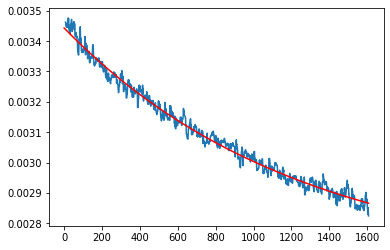

(0, 0, 2)


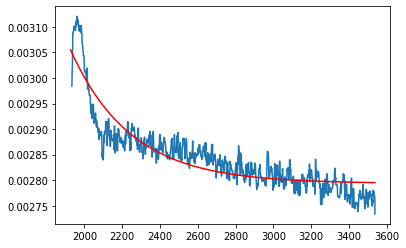

(0, 0, 4)


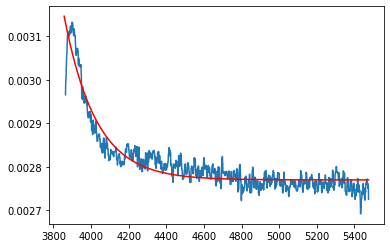

(0, 0, 6)


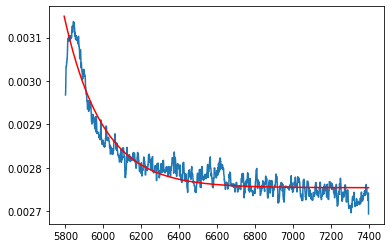

(0, 2, 0)


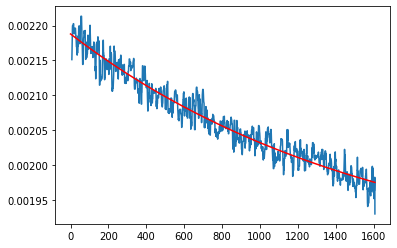

(0, 2, 2)


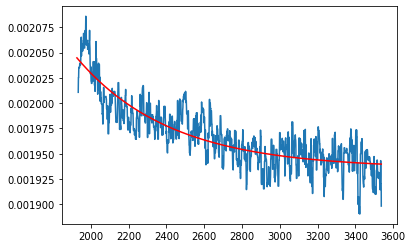

(0, 2, 4)


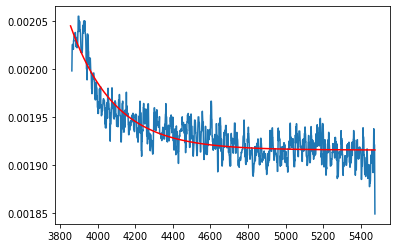

(0, 2, 6)


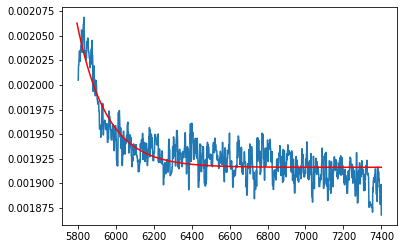

(0, 3, 0)


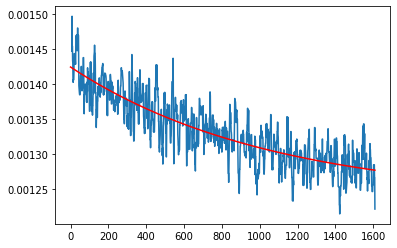

(0, 3, 2)


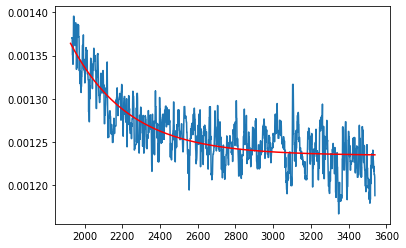

(0, 3, 4)


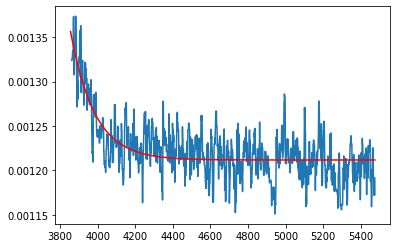

(0, 3, 6)


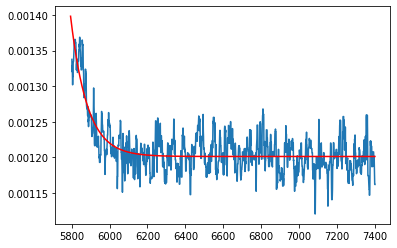

(0, 4, 0)


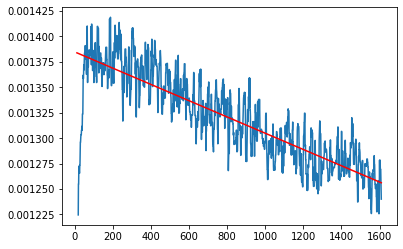

(0, 4, 2)


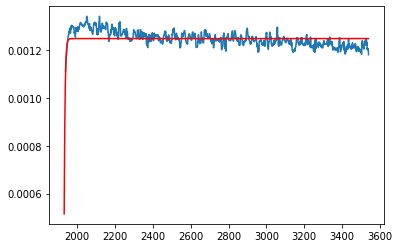

(0, 4, 4)


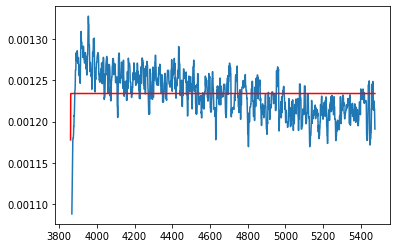

(0, 4, 6)


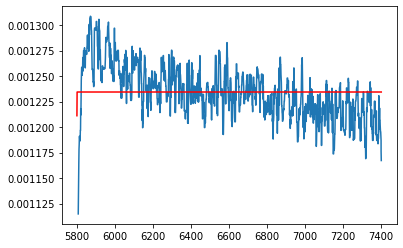

(0, 5, 0)


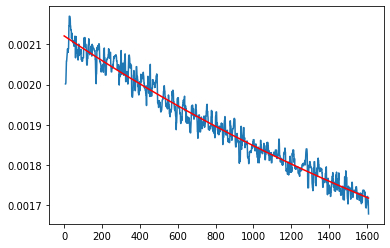

(0, 5, 2)


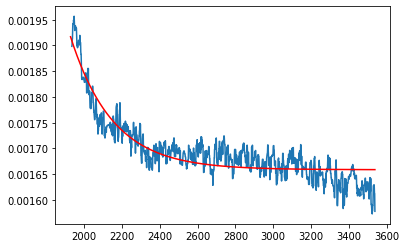

(0, 5, 4)


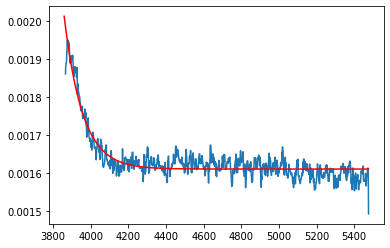

(0, 5, 6)


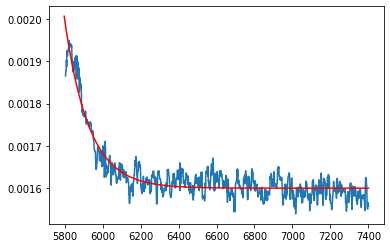

(1, 0, 0)


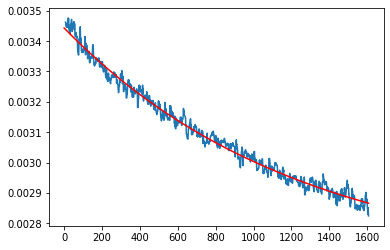

(1, 0, 2)


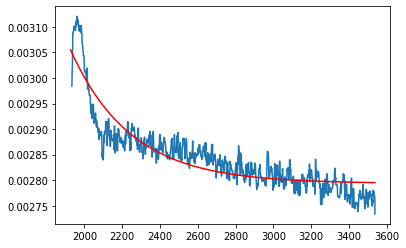

(1, 0, 4)


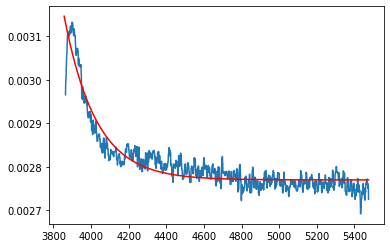

(1, 0, 6)


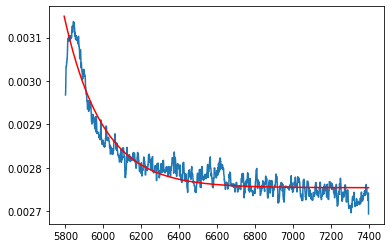

(1, 2, 0)


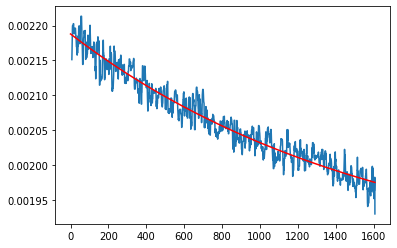

(1, 2, 2)


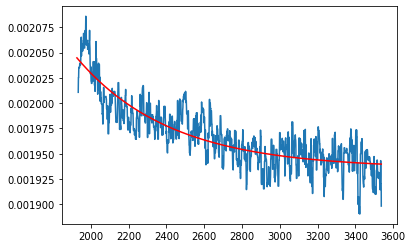

(1, 2, 4)


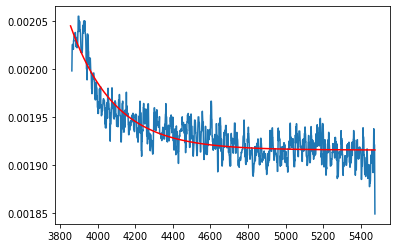

(1, 2, 6)


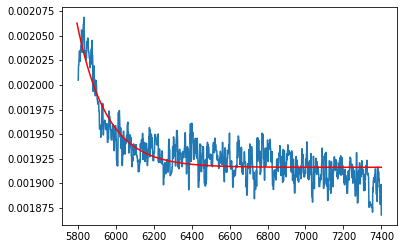

(1, 3, 0)


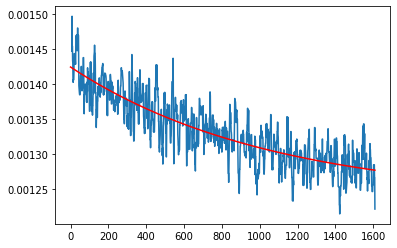

(1, 3, 2)


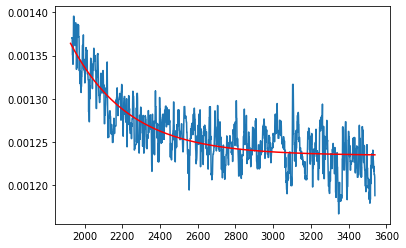

(1, 3, 4)


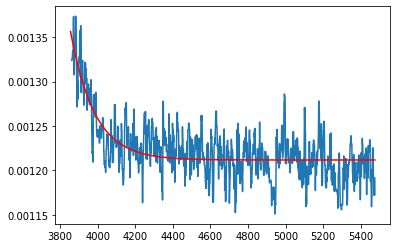

(1, 3, 6)


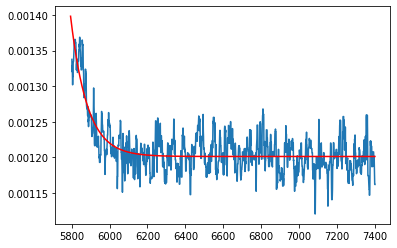

(1, 4, 0)


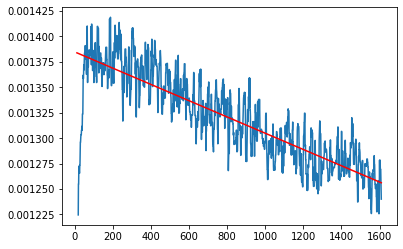

(1, 4, 2)


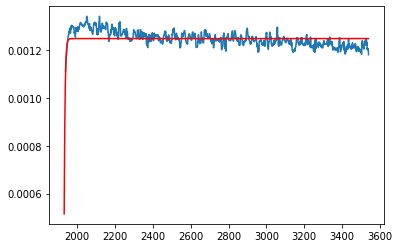

(1, 4, 4)


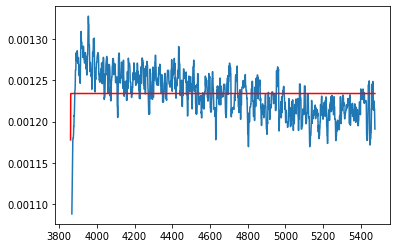

(1, 4, 6)


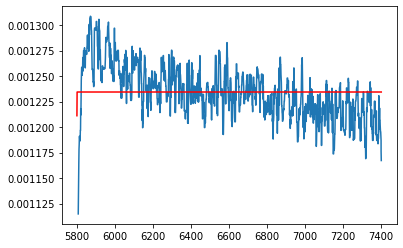

(1, 5, 0)


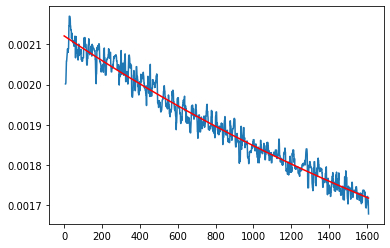

(1, 5, 2)


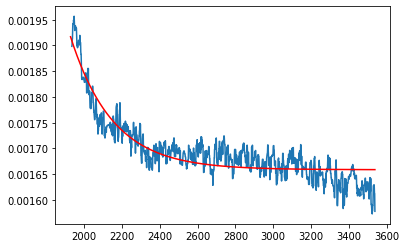

(1, 5, 4)


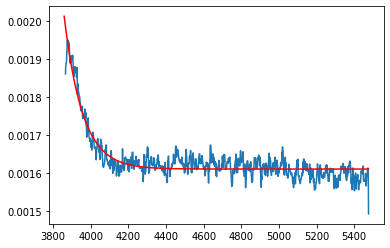

(1, 5, 6)


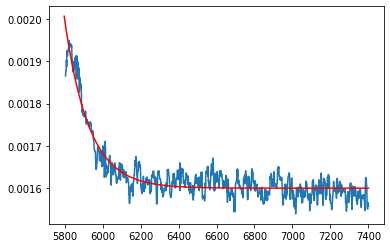

(2, 0, 0)


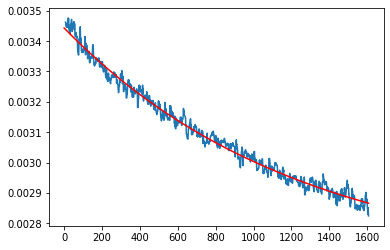

(2, 0, 2)


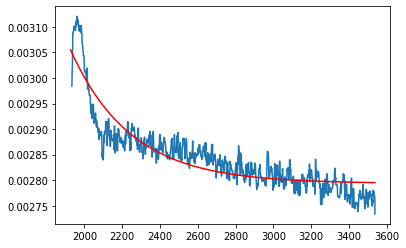

(2, 0, 4)


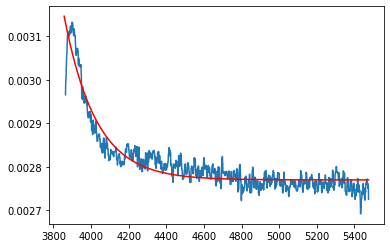

(2, 0, 6)


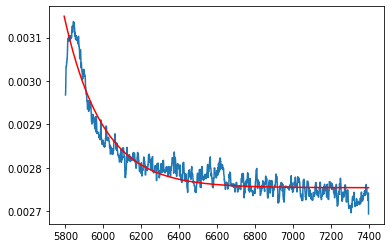

(2, 2, 0)


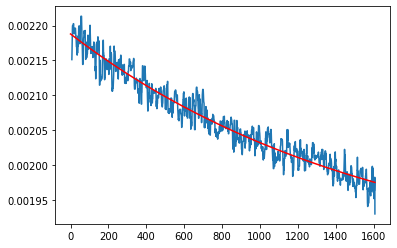

(2, 2, 2)


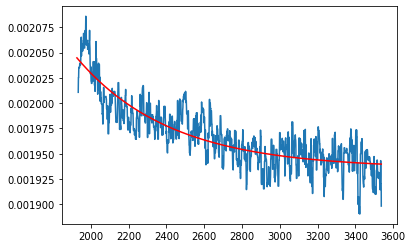

(2, 2, 4)


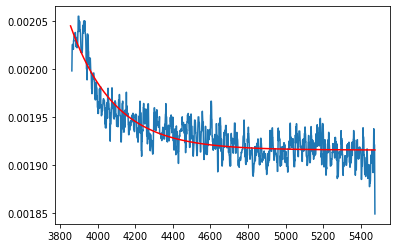

(2, 2, 6)


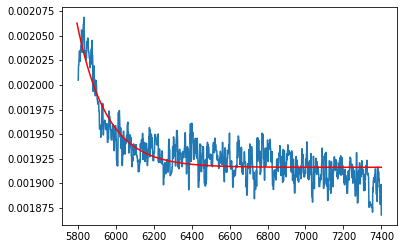

(2, 3, 0)


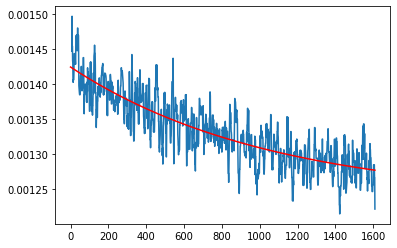

(2, 3, 2)


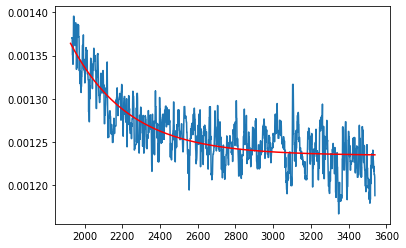

(2, 3, 4)


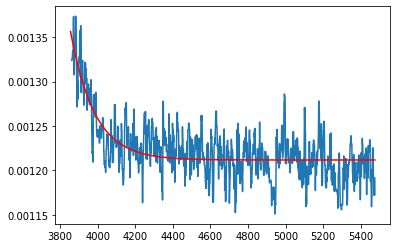

(2, 3, 6)


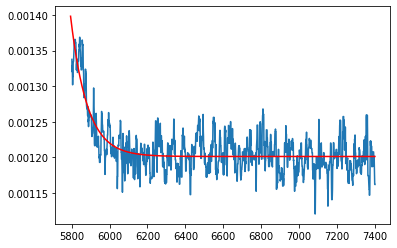

(2, 4, 0)


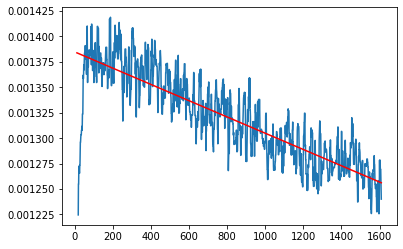

(2, 4, 2)


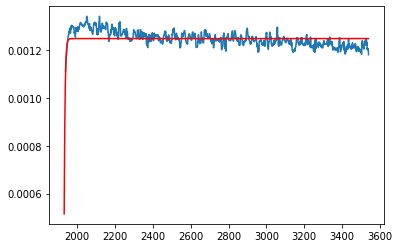

(2, 4, 4)


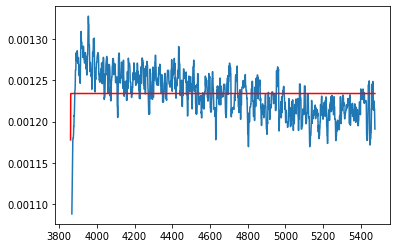

(2, 4, 6)


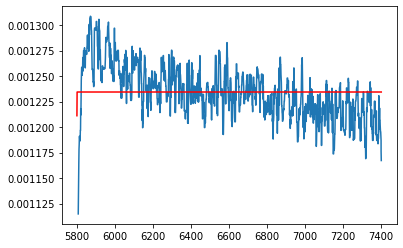

(2, 5, 0)


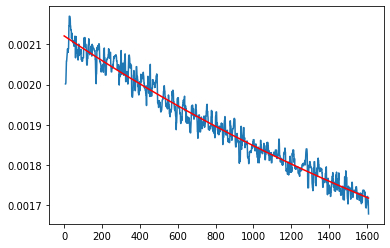

(2, 5, 2)


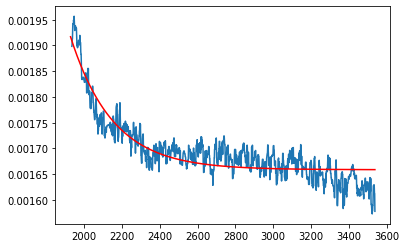

(2, 5, 4)


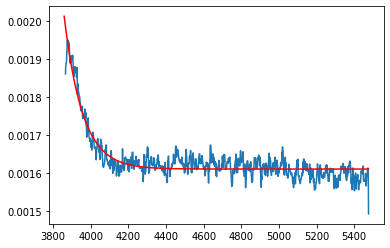

(2, 5, 6)


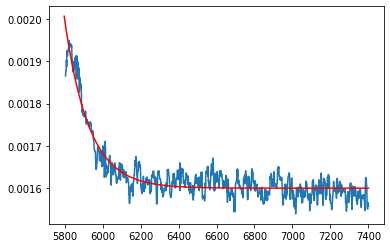

(3, 0, 0)


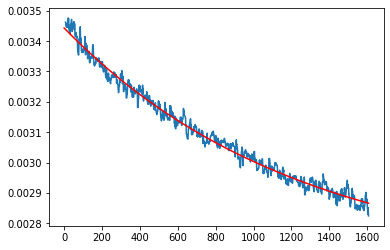

(3, 0, 2)


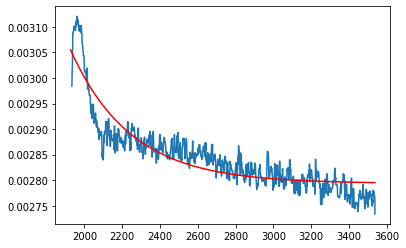

(3, 0, 4)


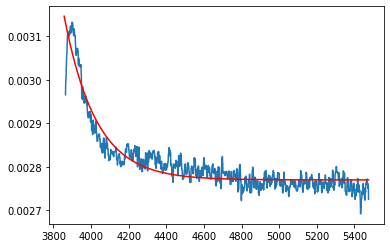

(3, 0, 6)


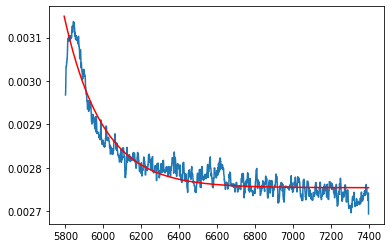

(3, 2, 0)


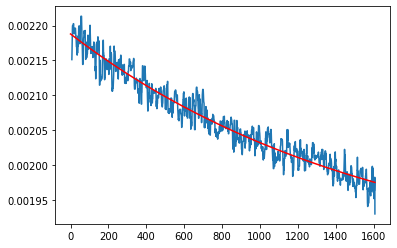

(3, 2, 2)


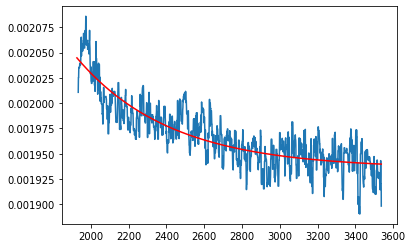

(3, 2, 4)


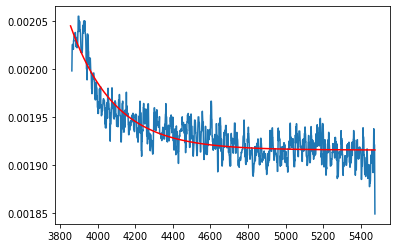

(3, 2, 6)


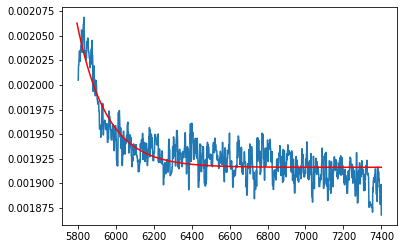

(3, 3, 0)


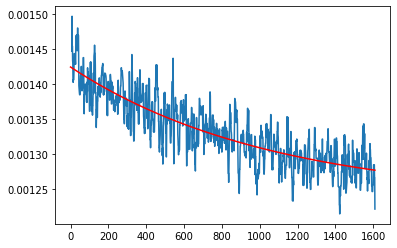

(3, 3, 2)


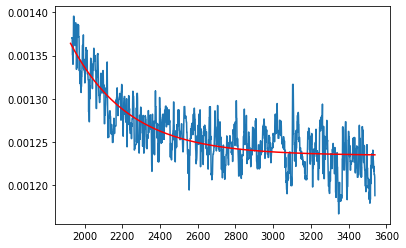

(3, 3, 4)


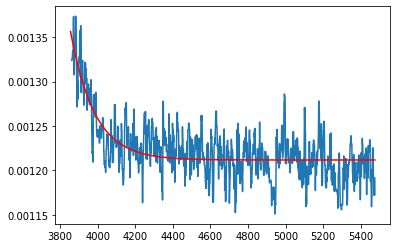

(3, 3, 6)


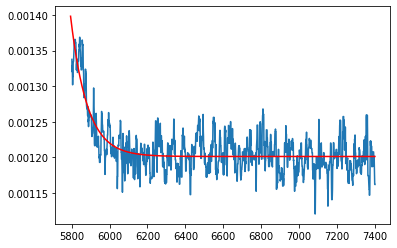

(3, 4, 0)


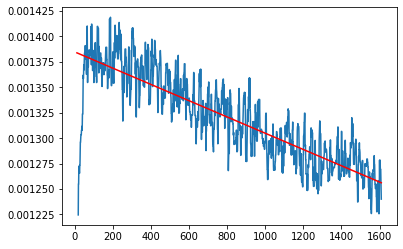

(3, 4, 2)


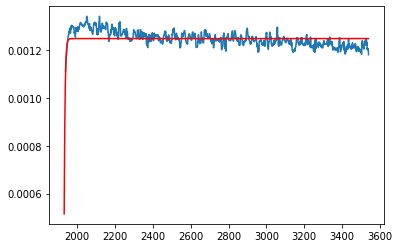

(3, 4, 4)


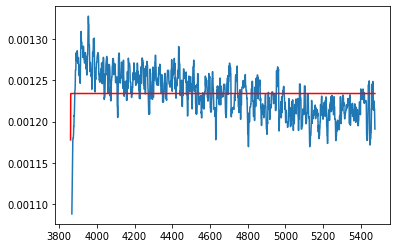

(3, 4, 6)


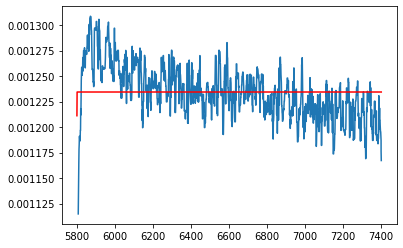

(3, 5, 0)


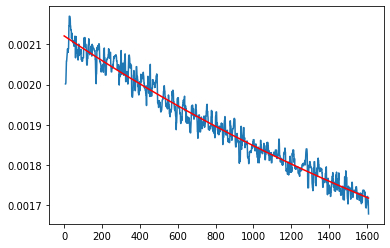

(3, 5, 2)


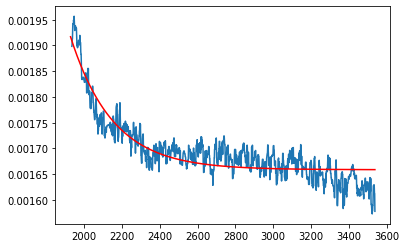

(3, 5, 4)


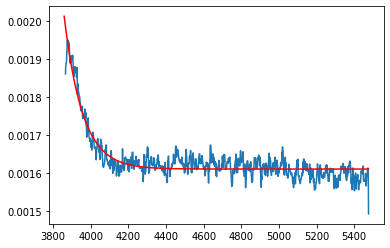

(3, 5, 6)


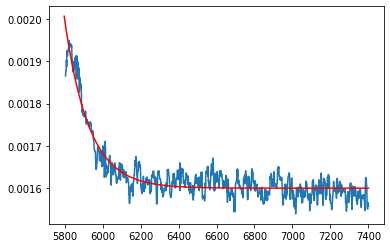

(4, 0, 0)


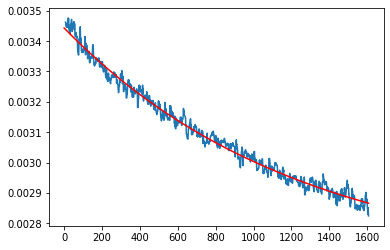

(4, 0, 2)


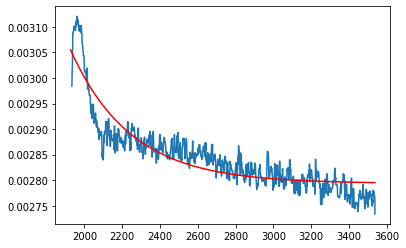

(4, 0, 4)


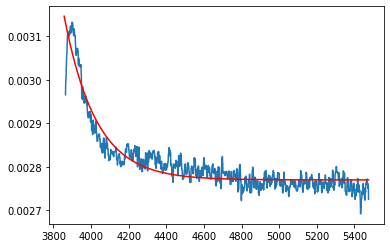

(4, 0, 6)


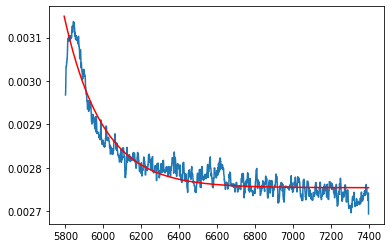

(4, 2, 0)


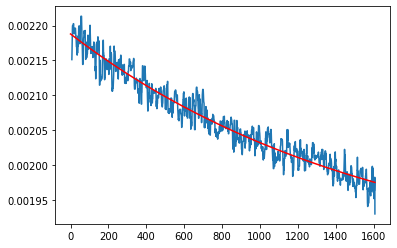

(4, 2, 2)


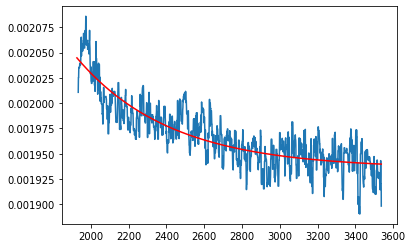

(4, 2, 4)


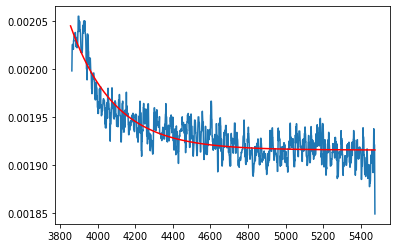

(4, 2, 6)


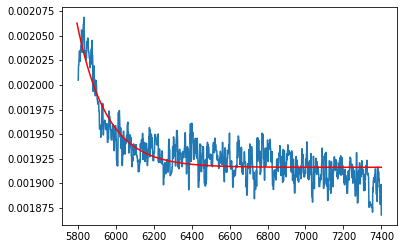

(4, 3, 0)


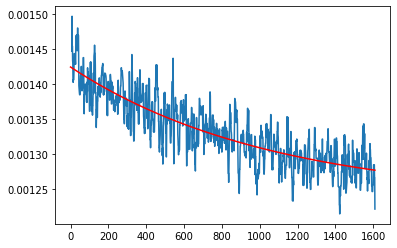

(4, 3, 2)


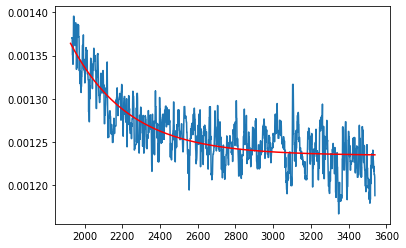

(4, 3, 4)


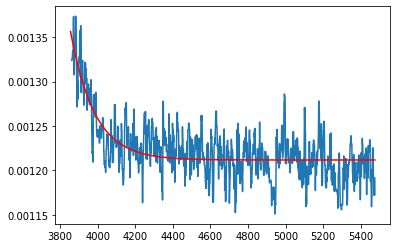

(4, 3, 6)


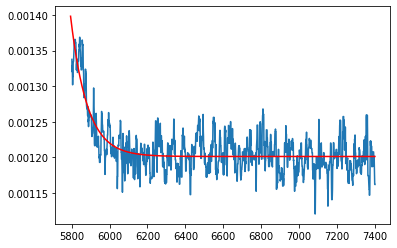

(4, 4, 0)


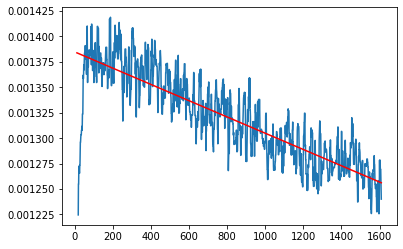

(4, 4, 2)


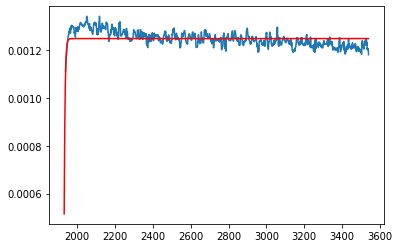

(4, 4, 4)


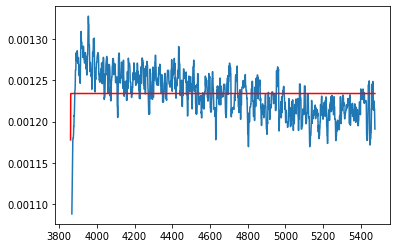

(4, 4, 6)


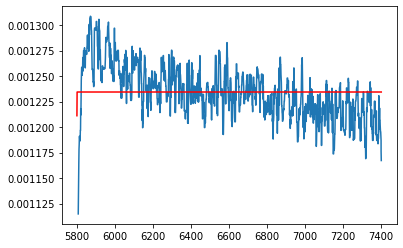

(4, 5, 0)


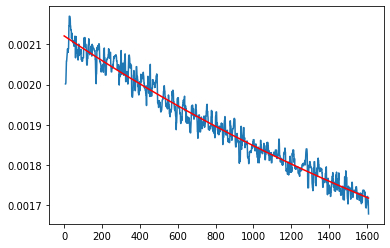

(4, 5, 2)


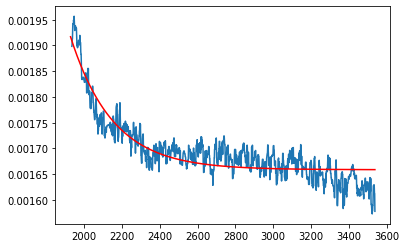

(4, 5, 4)


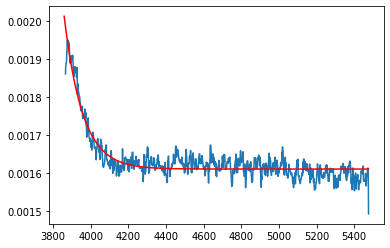

(4, 5, 6)


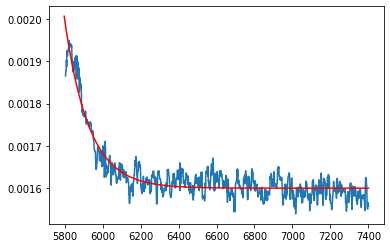

(5, 0, 0)


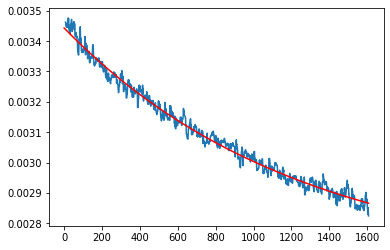

(5, 0, 2)


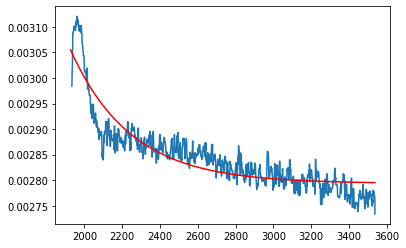

(5, 0, 4)


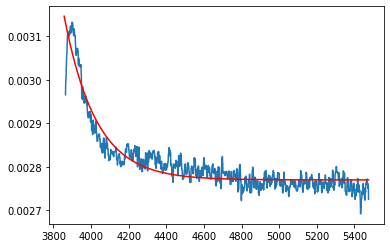

(5, 0, 6)


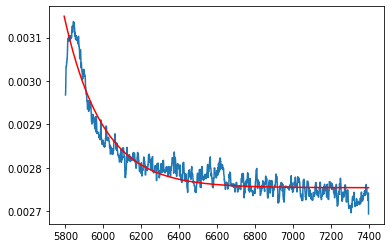

(5, 2, 0)


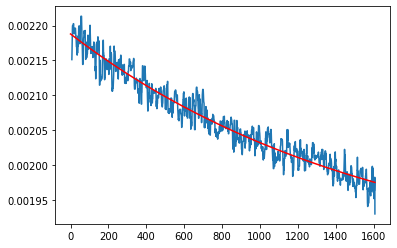

(5, 2, 2)


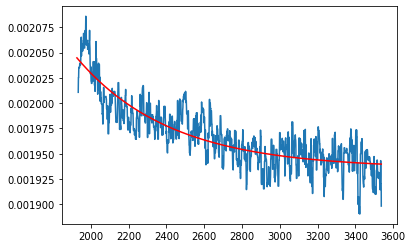

(5, 2, 4)


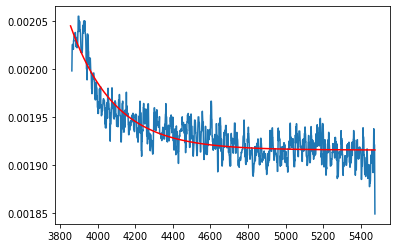

(5, 2, 6)


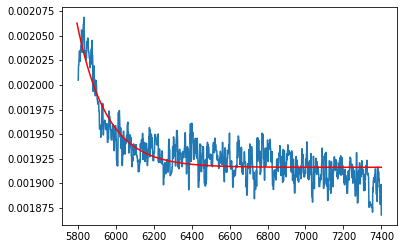

(5, 3, 0)


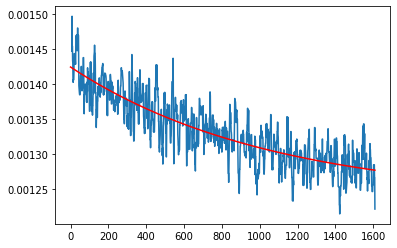

(5, 3, 2)


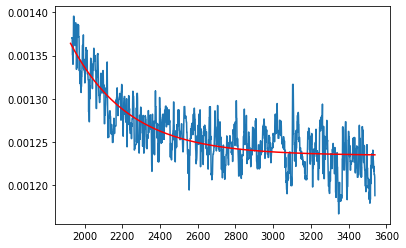

(5, 3, 4)


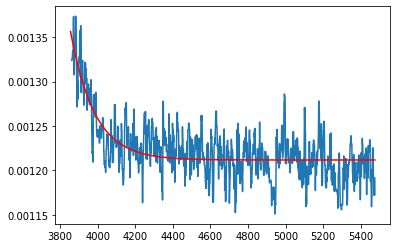

(5, 3, 6)


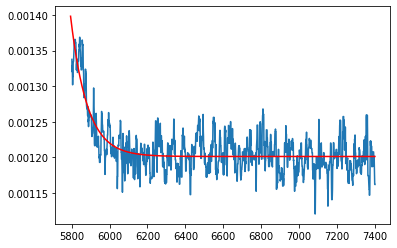

(5, 4, 0)


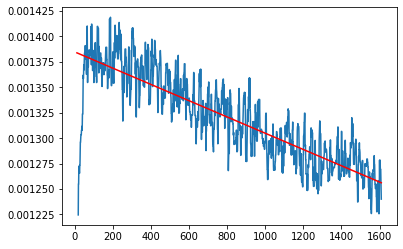

(5, 4, 2)


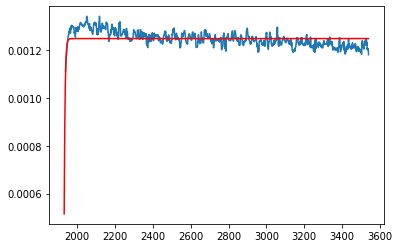

(5, 4, 4)


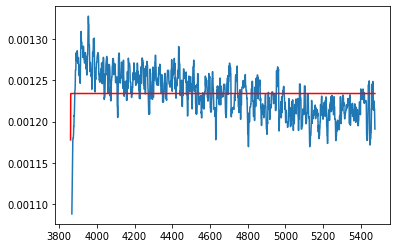

(5, 4, 6)


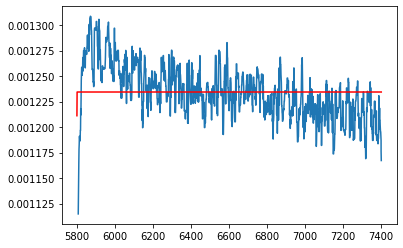

(5, 5, 0)


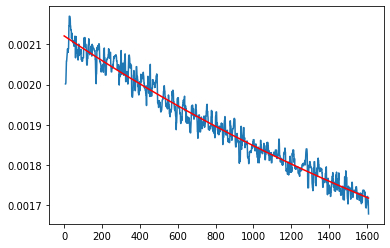

(5, 5, 2)


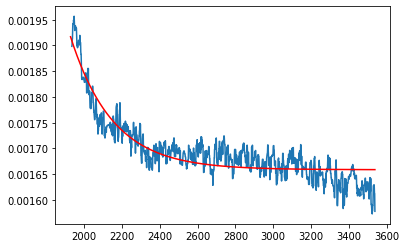

(5, 5, 4)


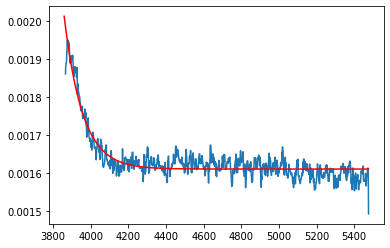

(5, 5, 6)


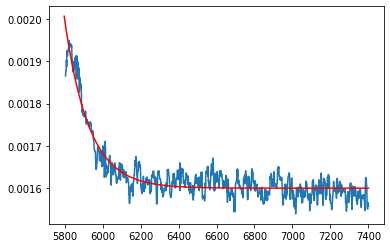

(6, 0, 0)


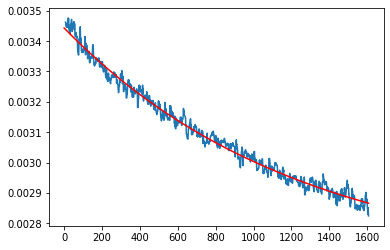

(6, 0, 2)


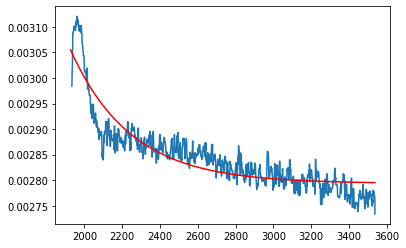

(6, 0, 4)


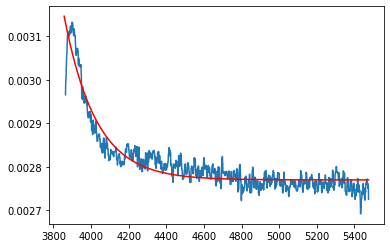

(6, 0, 6)


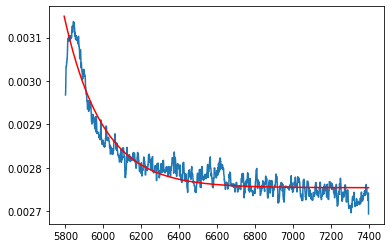

(6, 2, 0)


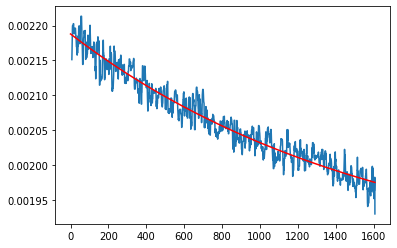

(6, 2, 2)


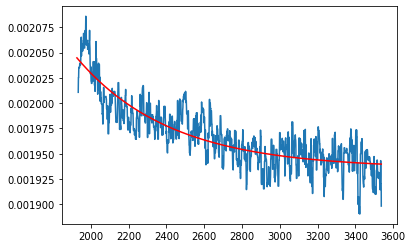

(6, 2, 4)


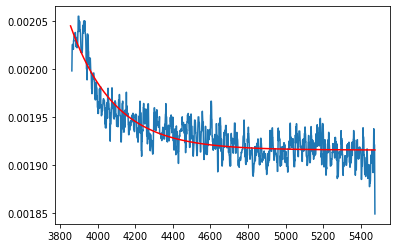

(6, 2, 6)


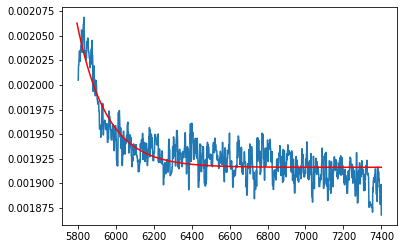

(6, 3, 0)


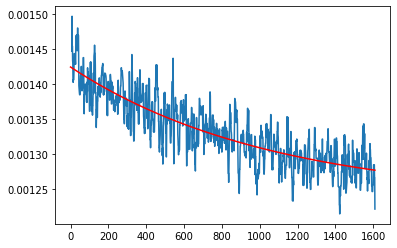

(6, 3, 2)


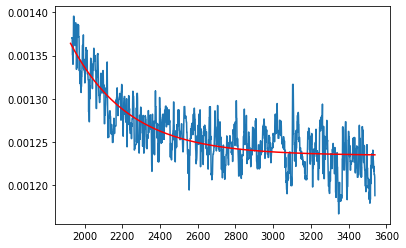

(6, 3, 4)


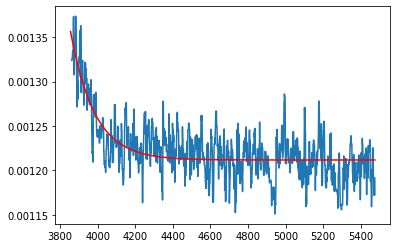

(6, 3, 6)


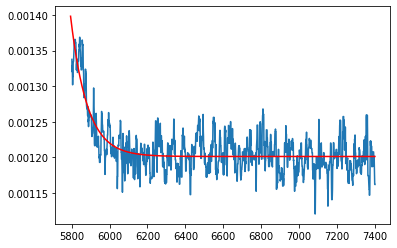

(6, 4, 0)


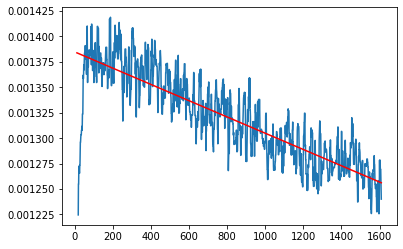

(6, 4, 2)


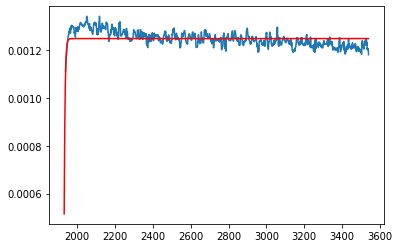

(6, 4, 4)


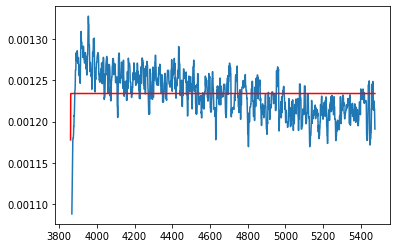

(6, 4, 6)


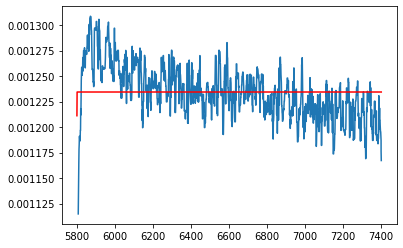

(6, 5, 0)


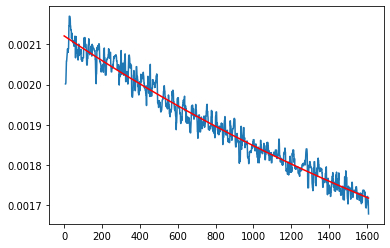

(6, 5, 2)


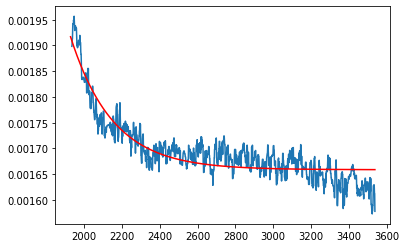

(6, 5, 4)


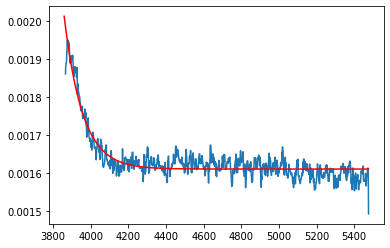

(6, 5, 6)


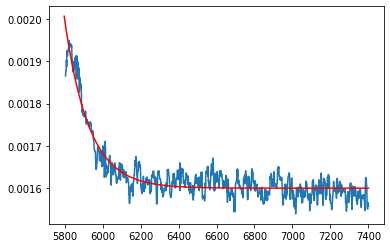

(7, 0, 0)


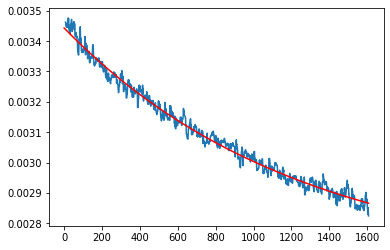

(7, 0, 2)


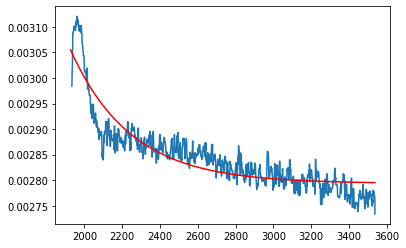

(7, 0, 4)


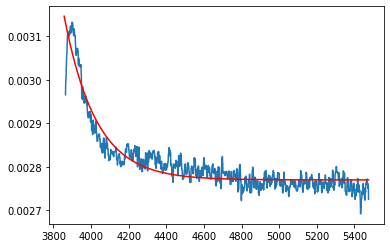

(7, 0, 6)


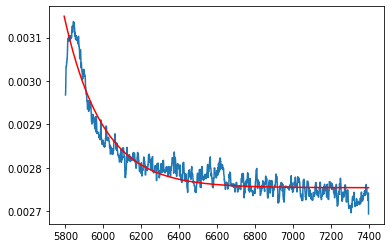

(7, 2, 0)


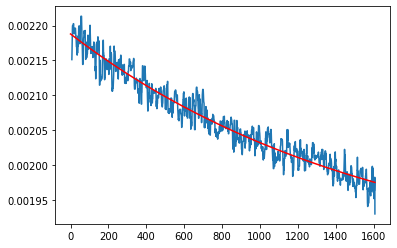

(7, 2, 2)


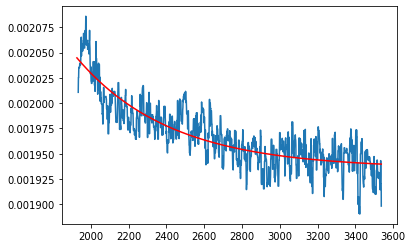

(7, 2, 4)


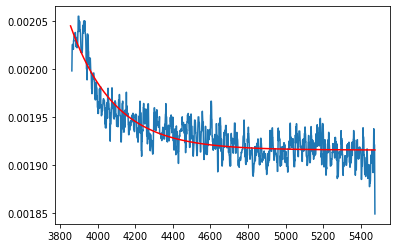

(7, 2, 6)


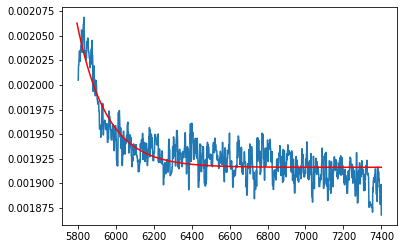

(7, 3, 0)


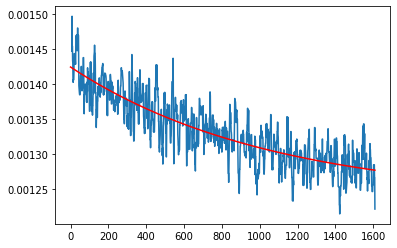

(7, 3, 2)


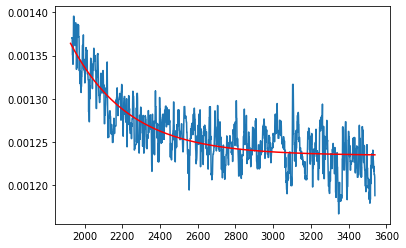

(7, 3, 4)


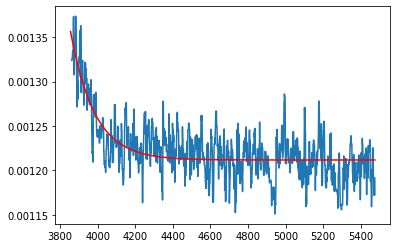

(7, 3, 6)


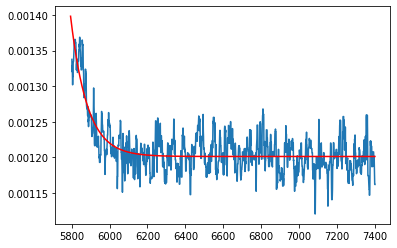

(7, 4, 0)


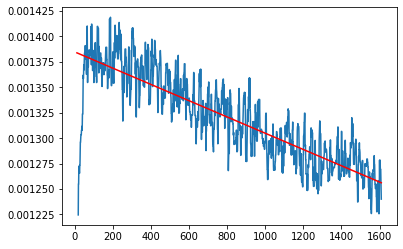

(7, 4, 2)


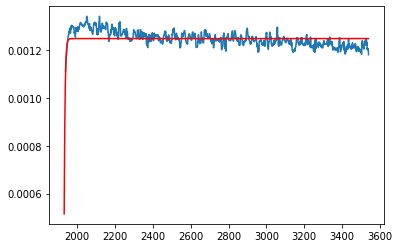

(7, 4, 4)


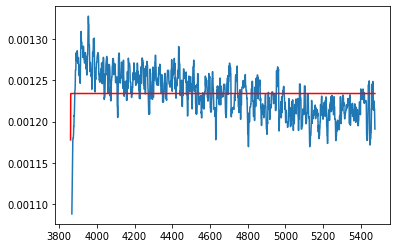

(7, 4, 6)


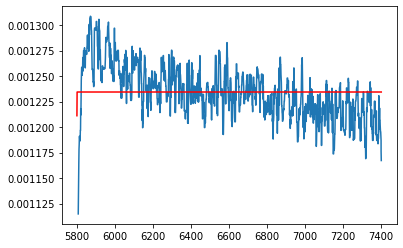

(7, 5, 0)


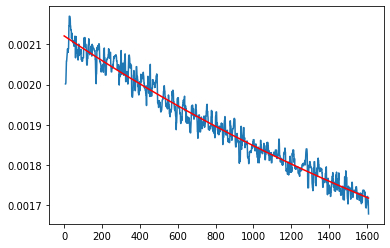

(7, 5, 2)


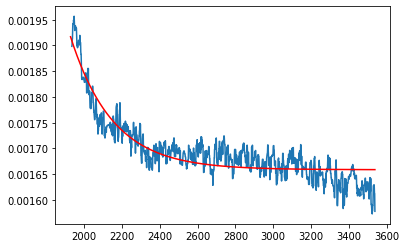

(7, 5, 4)


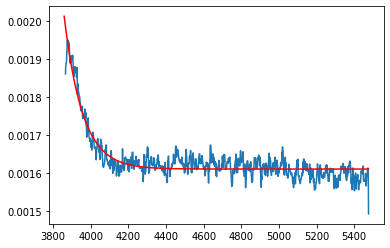

(7, 5, 6)


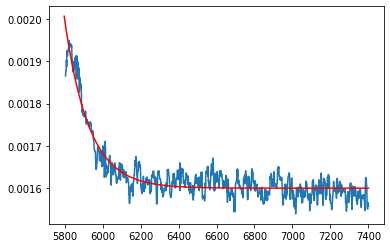

(8, 0, 0)


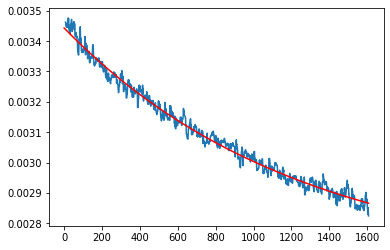

(8, 0, 2)


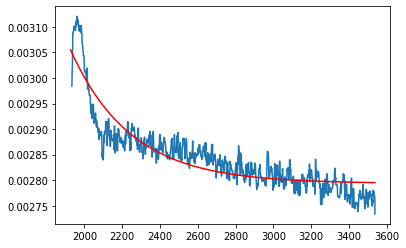

(8, 0, 4)


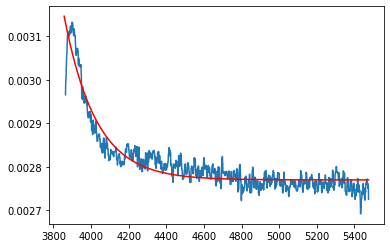

(8, 0, 6)


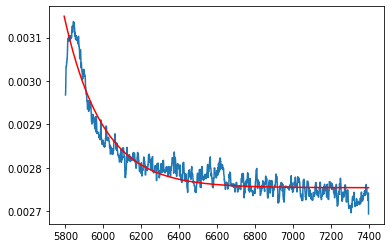

(8, 2, 0)


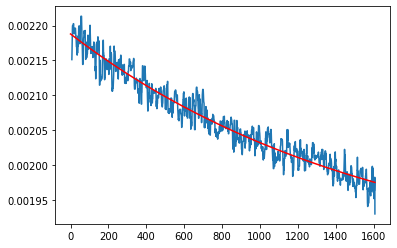

(8, 2, 2)


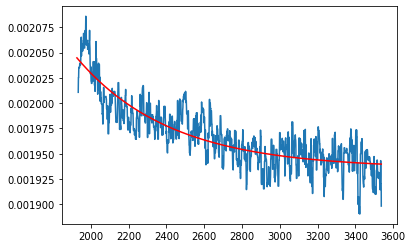

(8, 2, 4)


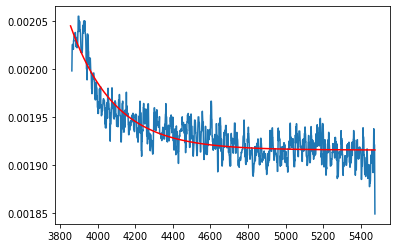

(8, 2, 6)


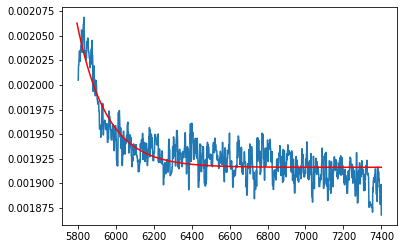

(8, 3, 0)


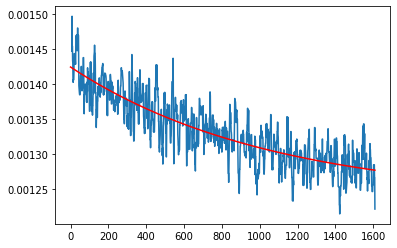

(8, 3, 2)


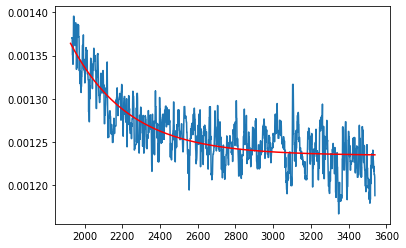

(8, 3, 4)


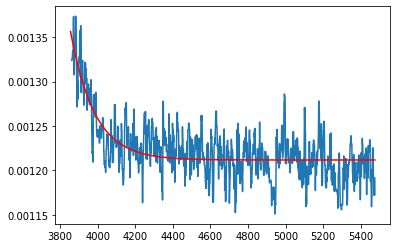

(8, 3, 6)


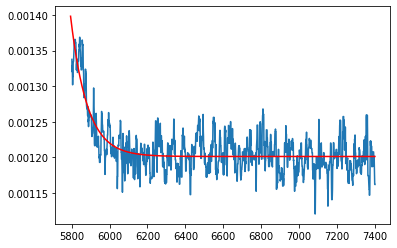

(8, 4, 0)


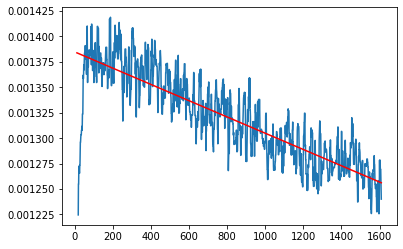

(8, 4, 2)


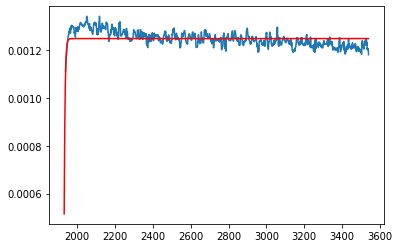

(8, 4, 4)


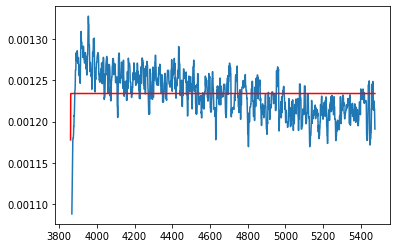

(8, 4, 6)


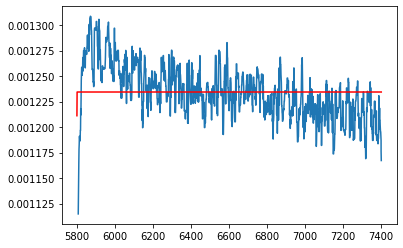

(8, 5, 0)


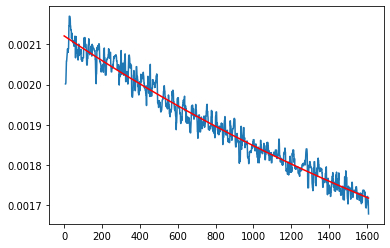

(8, 5, 2)


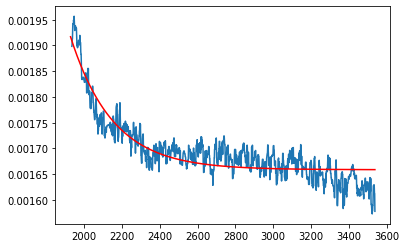

(8, 5, 4)


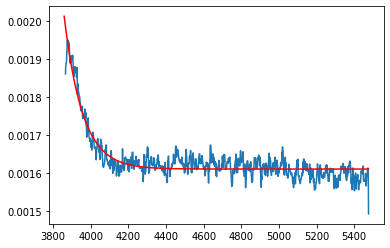

(8, 5, 6)


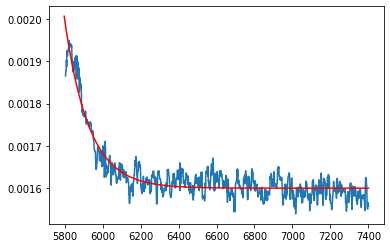

(9, 0, 0)


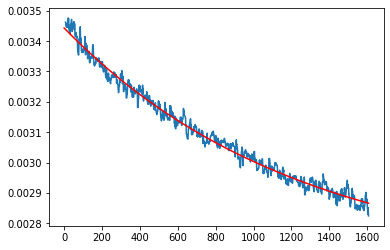

(9, 0, 2)


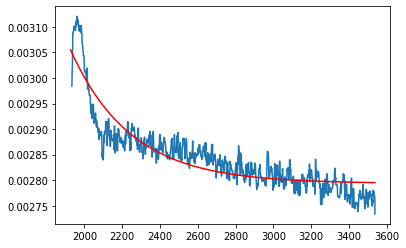

(9, 0, 4)


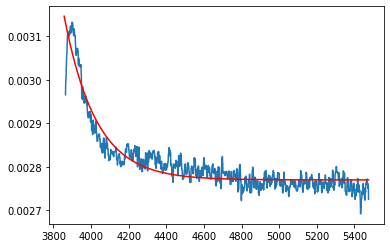

(9, 0, 6)


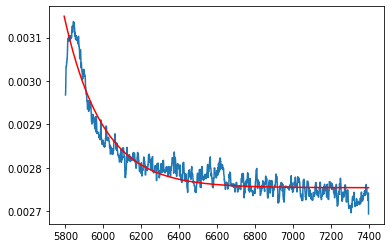

(9, 2, 0)


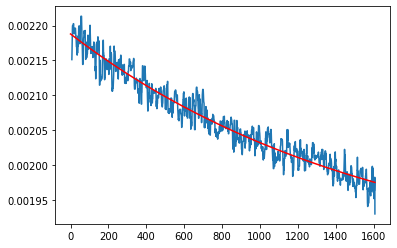

(9, 2, 2)


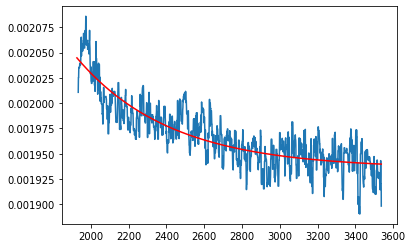

(9, 2, 4)


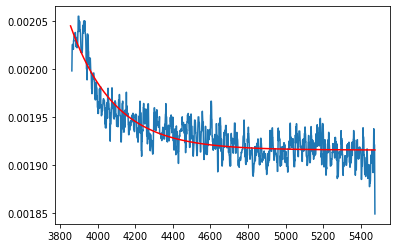

(9, 2, 6)


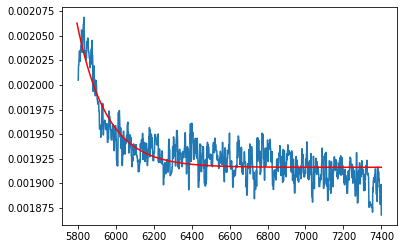

(9, 3, 0)


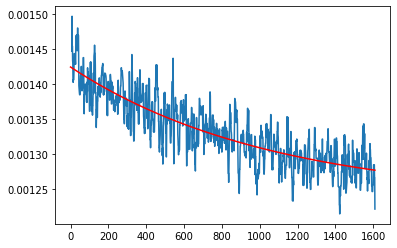

(9, 3, 2)


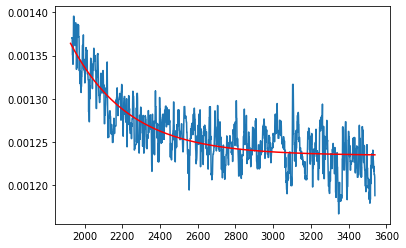

(9, 3, 4)


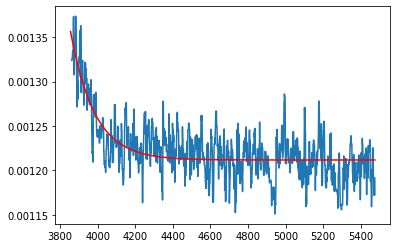

(9, 3, 6)


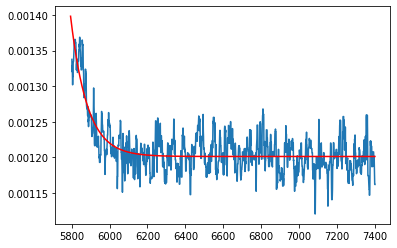

(9, 4, 0)


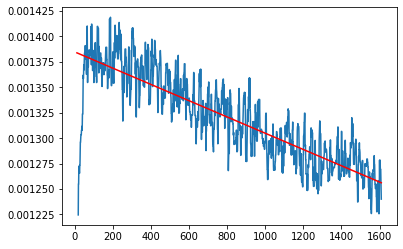

(9, 4, 2)


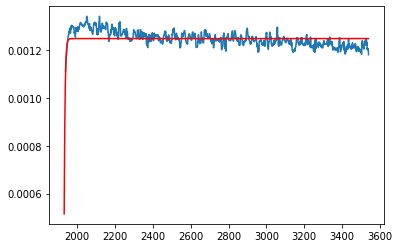

(9, 4, 4)


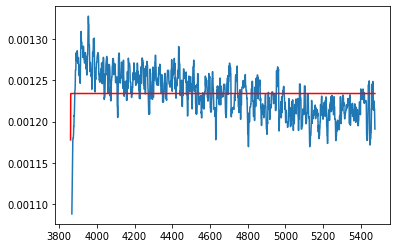

(9, 4, 6)


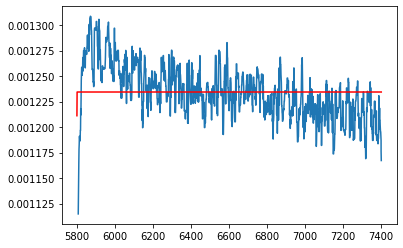

(9, 5, 0)


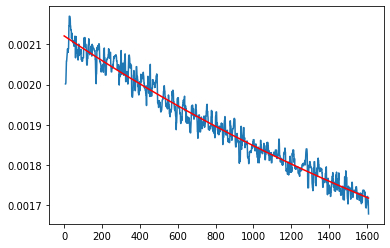

(9, 5, 2)


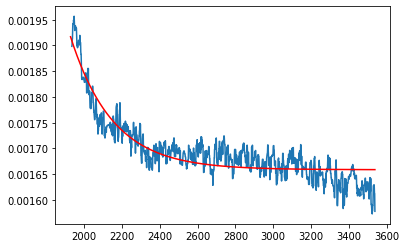

(9, 5, 4)


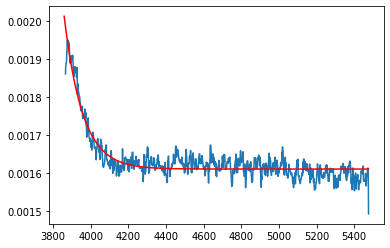

(9, 5, 6)


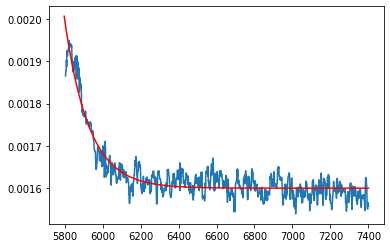

In [39]:
# for params, data in df.groupby (['measurement', 'channel','cycle']):
#     print (params)
#     fig, ax = plt.subplots ()
#     ax.plot (
#         data.time,
#         data.power.rolling (8).median ()
#     )
#     ax.plot (
#         data.time,
#         data.calculated,
#         c = 'r'
#     )
#     plt.show ()
#     plt.close ()

In [3]:
#     ipt = A1/2.7182 + P0
#     t1 = df.iloc[(df.power-ipt).abs().argsort()[:1]].index.values

In [38]:
# def remove_fit (df):
#     '''
#     Removes a value from the fit function if the ratio of the 
#     corresponding std and the value is bigger than 0.2.
#     :param df: A Pandas DataFrame obtained by using fit_exp function.
#     :returns: A DataFrame in which the erroneous fit values were substituted by NaN.
#     '''
    
#     cpgb = df.groupby (level = ['channel', 'parameter'], axis = 1)
#     fit = []
#     for name, data in cpgb:
#         d = data [(*name, 'value')].mask (abs (data[(*name, 'value')]) < (data[(*name, 'std')] / 0.2))
#         fit.append (d)
#     fit = pd.concat (fit, axis = 1)
#     return fit

In [80]:
#     if isinstance (df.columns, pd.MultiIndex):
#         s_df = df.xs (column, level = 'metrics', axis = 1, drop_level = False).droplevel (level = 'channel', axis = 1)
#         column = s_df [column]
#     else:
#         column = df [column]
#     grd = np.gradient (column.abs ().rolling (8, min_periods = None).mean ())
    

In [44]:
# def import_mpp_and_fit (
#     folder, 
#     skiprows = 17,
#     add_cycles = True,
#     remove_odd = True,
#     fit_exponential = True,
#     number_of_channels = 8
# ):
#     '''
#     Imports MPP data, assigns cycles count, relative time as well as calculated data
#     column after fitting an exponential curve.
#     :param folder: Data path, instead of channel number parentheses {} are used.
#     :param skiprows: how many rows to skip. [Default = 17]
#     :param add_cycles: Assigns cycle count. [Default = True]
#     :param remove odd: Removes data for odd cycles. [Default = True]
#     :param fit_exponential: Fits exponential function to the data. [Default = True]
#     :param number_of_channels: Number of channels used in the measurement. If one of the channels 
#     is not present, a statement will be printed out stating which channel wasn't found.
#     :returns: A Pandas DataFrame with MPP data and a DataFrame with calculated parameters.
#     '''
    
#     df_f = []
#     calc_params_f = []
#     for ch in range (number_of_channels):
#         try:
#             df = bldp.import_mpp_tracking_data (folder.format (ch), skiprows = skiprows)
                        
#         except: 
#             try:
#                 df = bldp.import_mpp_tracking_data (folder, file_pattern = 'ch-{}.csv'.format (ch), skiprows = skiprows)
#             except Exception as error: 
#                 print ('Channel {} not found.'.format (ch))
#                 logging.debug (error)
#                 continue

#         # assigning cycles
#         if add_cycles:   
#             df.reset_index (level = 0, inplace = True)
#             df = assign_cycles (df, 'power', mpl = 3)

#         #removing odd cycles
#         if remove_odd:
#             df = remove_odd_cycles (df)

#         # calculating relative time
#         if add_cycles:
#             df = relative_time (df, ch)

#         # fitting exp
#         if fit_exponential:
#             calculated = []
#             if add_cycles:      
#                 power = df.droplevel ('channel', axis = 1).droplevel('time')
#                 fit_df = df.xs ('r_time', level = 'metrics', axis = 1, drop_level = False).droplevel ('time').droplevel ('channel', axis = 1)
#                 fit_df ['power'] = power.power
#                 fit_df.set_index ('r_time', append = True, inplace = True)
#                 calc_params = []
#                 cycles = set (df.index.get_level_values ('cycle'))
#                 for cy in cycles:
#                     cut_fit_df = fit_df.xs (cy, level = 'cycle')
#                     p = fit_exp (cut_fit_df)
#                     calc = (p.A0.value.power * np.exp (-cut_fit_df.index.values/p.t1.value.power) + p.P0.value.power)
#                     calculated += list(calc)
#                     p ['cycle'] = cy
#                     p.set_index (['cycle'], append = True, inplace = True)
#                     calc_params.append (p)

#                 df [ch, 'calculated'] = calculated
#                 calc_params = pd.concat (calc_params, axis = 0)
#                 calc_params = std.insert_index_levels (calc_params, ch, 'channel')

#             else:
#                 power = df.droplevel ('channel', axis = 1)
#                 cut_fit_df = power.drop (['voltage', 'current'], axis = 1)
#                 calc_params = fit_exp (cut_fit_df)
#                 calculated = (calc_params.A0.value.power * np.exp (-cut_fit_df.index.values /calc_params.t1.value.power) + calc_params.P0.value.power)
#                 df [ch, 'calculated'] = calculated
            
#             # final DataFrames
#             df_f.append (df)
#             calc_params_f.append (calc_params)
            
#         else:
#             df_f.append (df)
    
#     if fit_exponential:    
#         df_f = pd.concat (df_f, axis = 1)
#         calc_params_f = pd.concat (calc_params_f, axis = 1)
        
#     else:
#         df_f = pd.concat (df_f, axis = 1)
       
#     return (df_f, calc_params_f)

In [4]:
def degradation_params (df):
    '''
    Takes exponential fit parameters for MPP tracking and calculates power difference
    and time ratio.
    :param df: A Pandas DataFrame with MPP tracking exponential fit parameters.
    :returns: A Pandas DataFrame with calculated degradation parameters.
    '''

    channels = set (df.columns.get_level_values ('channel'))
    cycles = list (df.index.get_level_values ('cycle'))
    del cycles [-1]
    ch = 0
    cy = 0

    product = [channels, ['P_diff', 't_ratio', 'P_diff_norm', 'A_ratio'], ['value', 'std']]
    idx = pd.Index (cycles, name = 'cycle')
    cln = pd.MultiIndex.from_product (product, names = ['channel', 'parameter', 'metric'])
    deg_params = pd.DataFrame (index = idx, columns = cln)

    for ch in channels:
        P_diff = []
        P_diff_std = []
        t_ratio = []
        t_ratio_std = []
        P_diff_norm = []
        P_diff_norm_std = []
        A_ratio = []
        for cy in cycles:
            # calculating P_diff: (P0cy - A1cy+2 - P0cy+2)
            P = df.loc [('power', cy), (ch, 'P0', 'value')]
            P_2 = df.loc [('power', cy + 2), (ch, 'P0', 'value')]
            A_2 = df.loc [('power', cy + 2), (ch, 'A0', 'value')]
            p_diff = P - A_2 - P_2
            P_diff.append (p_diff)

            # calculating P_diff std: sqrt(std(P0cy)^2 + std(A1cy+2)^2 + std(P0cy+2)^2)
            P_std = df.loc [('power', cy), (ch, 'P0', 'std')]
            P_2_std = df.loc [('power', cy + 2), (ch, 'P0', 'std')]
            A_2_std = df.loc [('power', cy + 2), (ch, 'A0', 'std')]
            p_diff_std = np.sqrt (P_std ** 2 + A_2_std ** 2 + P_2_std ** 2)
#             p_diff_std = np.format_float_scientific (p_diff_std, precision = 4)
            P_diff_std.append (p_diff_std)

            # calculating t_ratio: (t1cy+2 / t1cy), should be more than 1 if the degradation slows down
            t_2 = df.loc [('power', cy + 2), (ch, 't1', 'value')]
            t = df.loc [('power', cy), (ch, 't1', 'value')]
            t_r = t_2 / t
            t_ratio.append (t_r)

            # calculating t_ratio std: sqrt((std(t1cy+2)/t1cy+2)^2 + (std(t1cy)/t1cy)^2))*(t1cy+2 / t1cy)
            t_2_std = df.loc [('power', cy + 2), (ch, 't1', 'std')]
            t_std = df.loc [('power', cy), (ch, 't1', 'std')]
            t_r_std = np.sqrt (((t_2_std / t_2) ** 2 + (t_std / t) ** 2)) * t_r
            t_ratio_std.append (t_r_std)
            
            # calculating P_diff_norm: (P0cy - A1cy+2 - P0cy+2)/abs(P0cy)
            p_diff_norm = p_diff/abs (P)
            P_diff_norm.append (p_diff_norm)
            
            # calculating P_diff_norm_std sqrt((std(p_diff)/p_diff)^2+(std(P0cy)/p0cy)^2)*p_diff_norm
            p_diff_norm_std = np.sqrt((p_diff_std/p_diff) ** 2 + (P_std/P) ** 2) * p_diff_norm
            P_diff_norm_std.append (p_diff_norm_std)
            
            # calculating A_ratio
            A = df.loc [('power', 0), (ch, 'A0', 'value')]
            A_2 = df.loc [('power', cy + 2), (ch, 'A0', 'value')]
            a_ratio = A_2 / A
            A_ratio.append (a_ratio)
            

        deg_params [ch, 'P_diff', 'value'] = P_diff
        deg_params [ch, 'P_diff', 'std'] = P_diff_std
        deg_params [ch, 't_ratio', 'value'] = t_ratio
        deg_params [ch, 't_ratio', 'std'] = t_ratio_std
        deg_params [ch, 'P_diff_norm', 'value'] = P_diff_norm
        deg_params [ch, 'P_diff_norm', 'std'] = P_diff_norm_std
        deg_params [ch, 'A_ratio', 'value'] = A_ratio
        
    
    return deg_params.stack (level = 'parameter').stack (level = 'metric').unstack (level = 'cycle')

In [31]:
def import_jvs (folder, number_of_channels = 8):
    '''
    Imports JV data before and after the MPP tracking.
    :param folder: Data path, instead of channel number parentheses {} are used.
    :param number_of_channels: Number of channels used in the measurement. If one of the channels 
    is not present, a statement will be printed out stating which channel wasn't found. [Default = 8]
    :returns: A Pandas DataFrame with JV scans.
    '''
    channels = range (number_of_channels)
    before = []
    after = []
    for ch in channels:
        try: 
            b = bldp.import_mpp_jv_data (folder.format (ch), file_pattern = 'jv.csv', by_scan = False, channel_pattern = 'ch-<>')
            before.append (b)
            a = bldp.import_mpp_jv_data (folder.format (ch), file_pattern = 'jv_end.csv', by_scan = False, channel_pattern = 'ch-<>')
            after.append (a)
        except:
            print ('Channel {} not found.'.format (ch))
    
    before = pd.concat (before, axis = 1)
    after = pd.concat (after, axis = 1)
    df = pd.concat([before, after], keys = ['before', 'after'], names = ['when'], axis = 1)
    df = df.reorder_levels (['channel', 'when', None], axis = 1)
    df.sort_index (axis = 1, level = 'channel', inplace = True, sort_remaining = False)
    
    return df

def import_jv_new (folder, file_name = 'jv.csv', channels = [0, 1, 2, 3, 4, 5, 7]):
    ''''''
    metric = ['voltage', 'current', 'power']
    df = pd.read_csv ('{}/{}'.format (folder, file_name), header = [0, 1])
    col = pd.MultiIndex.from_product ([channels, metric], names = ['channel', None])
    df.columns = col
    return df

def import_jvs_new (folder, channels = [0, 1, 2, 3, 4, 5, 7]):
    before = import_jv_new (folder, channels = channels)
    after = import_jv_new (folder, file_name = 'jv_end.csv', channels = channels)
    df = pd.concat([before, after], keys = ['before', 'after'], names = ['when'], axis = 1)
    df = df.reorder_levels (['channel', 'when', None], axis = 1)
    df.sort_index (axis = 1, level = 'channel', inplace = True, sort_remaining = False)
    return df

def import_jvs_get_metrics (folder, channels = [0, 1, 2, 3, 4, 5, 7], **kwargs):
    '''
    Imports JV data before and after the MPP tracking and gets JV metrics.
    :param folder: Data path, instead of channel number parentheses {} are used.
    :param **kwargs: Additional arguments to pass to the import_jvs function.
    :returns: Pandas DataFrames with JV scans and JV metrics.
    '''
    try:
        jvs = import_jvs_new (folder, channels = channels)
    except:
        jvs = import_jvs (folder, **kwargs)

    metrics = get_jvs_metrics (jvs)
    return jvs, metrics

In [144]:
def get_mpp( df ):
    """
    Gets the maximum power point
    
    :param df: A Pandas DataFrame containing JV scans to evaluate
    :returns: A Pandas DataFrame with Vmpp with Jmpp and Pmpp
    """
    pmpp = pd.Series (df.power.min ())          # Pmpp
    vmpp = pd.Series (df.power.idxmin ())       # Vmpp
    jmpp = pd.Series (pmpp/ vmpp)               # Jmpp
       
    return pd.concat ((vmpp, jmpp, pmpp), keys = ['vmpp', 'jmpp', 'pmpp'], axis = 1)

def get_jsc( df ):
    """
    Get the short circuit current
    
    :param df: A Pandas DataFrame containing JV sweeps
    :returns: A Pandas Series of short circuit currents
    """
    jsc = pd.Series (df.current.loc [df.index.values.max ()])
    return jsc.rename( 'jsc' )


def get_voc( df ):
    """
    Get the open circuit voltage
    
    :param df: A Pandas DataFrame containing JV sweeps
    :returns: A Pandas Series of open circuit voltages
    """
    voc = pd.Series( df.index.values.min () )
    return voc.rename( 'voc' )

def get_jv_metrics( df ):
    """
    Creates a Pandas DataFrame containing metric about JV curves
    Metrics include maximum power point (vmpp, jmpp, pmpp), open circuit voltage,
    short circuit current, fill factor, and efficiency
    
    :params df: The DataFrame containing the JV curves
    :returns: A Pandas DataFrame containing information about the curves
    """
    metrics = [ get_mpp( df ), get_voc( df ), get_jsc( df ) ]
    metrics = pd.concat( metrics, axis = 1 )
    metrics = metrics.assign( ff = lambda x: x.pmpp/ ( x.voc* x.jsc )  )
    metrics.columns.name = 'metric'
    return metrics

def get_jvs_metrics (df):
    '''
    Gets JV metrics for measurements before and after the MPP tracking.
    :param df: A Pandas DataFrame with data indexed by channel and when.
    :returns: A Pandas DataFrame with JV metrics.
    '''
    channels = df.columns.get_level_values ('channel').unique ()
    metrics = []
    for ch in channels:
        # before
        df_cut = df.xs (ch, axis = 1, level = 'channel').xs ('before', axis = 1, level = 'when').dropna ()
        df_cut.set_index ('voltage', inplace = True)
        m_before = get_jv_metrics (df_cut).transpose ()
        # after
        df_cut = df.xs (ch, axis = 1, level = 'channel').xs ('after', axis = 1, level = 'when').dropna ()
        df_cut.set_index ('voltage', inplace = True)
        m_after = get_jv_metrics (df_cut).transpose ()
        
        m = pd.concat ([m_before, m_after], axis = 1, keys = ['before', 'after'], names = ['when', 'drop']
        ).droplevel ('drop', axis = 1)
        m = std.insert_index_levels (m, ch, 'channel')
        metrics.append (m)
        
    metrics = pd.concat (metrics, axis = 1)
    return metrics

In [23]:
def plot_mpp( ax, data, name ):
    
    try:
        data = data.droplevel ('cycle')
    except:
        pass
#     channels = set (data.columns.get_level_values ('channel'))

    ax.plot (data.loc [:,(slice (None), 'power')], label = 'measured')
    ax.plot (data.loc [:,(slice (None), 'calculated')], label = 'calculated')
#     data.get_legend ().remove ()
    ax.set_title (name, fontsize = 10)
    ax.set_xlabel ('')

In [9]:
def plot_mpp_cycles (ax, data, name):
    '''
    Reindexes the dataframe by r_time and plots power and the fitting data.
    '''
    channels = set (data.columns.get_level_values ('channel'))
    cycles = set (data.index.get_level_values ('cycle'))
    dfs = []

    for ch in channels:
        data_cut = data.loc[:, (ch, ('power', 'r_time', 'calculated'))]
        data_cut = data_cut.droplevel ('time').droplevel ('channel', axis = 1)
        data_cut.set_index ('r_time', append = True, inplace = True)
        data_cut = std.insert_index_levels (data_cut, ch, 'channel')
        data_cut.dropna (inplace = True)

        dfs_cut = []
        for cy in cycles:        
            ax.plot (data_cut.xs (cy, level = 'cycle', drop_level = False).unstack (level = 0), 
                     label = cy)

    ax.set_title (name, fontsize = 10)
    ax.set_xlabel( '' )
    
def plot_mpp_cycles_calculated (ax, data, name):
    '''
    Reindexes the dataframe by r_time and plots the fitting data.
    '''
    channels = set (data.columns.get_level_values ('channel'))
    cycles = set (data.index.get_level_values ('cycle'))
    dfs = []

    for ch in channels:
        data_cut = data.loc[:, (ch, ('r_time', 'calculated'))]
        data_cut = data_cut.droplevel ('time').droplevel ('channel', axis = 1)
        data_cut.set_index ('r_time', append = True, inplace = True)
        data_cut = std.insert_index_levels (data_cut, ch, 'channel')
        data_cut.dropna (inplace = True)

        dfs_cut = []
        for cy in cycles:        
            ax.plot (data_cut.xs (cy, level = 'cycle', drop_level = False).unstack (level = 0), 
                     label = cy)

    ax.set_title (name, fontsize = 10)
    ax.set_xlabel( '' )

def plot_mpp_cycles_measured (ax, data, name):
    '''
    Reindexes the dataframe by r_time and plots the fitting data.
    '''
    channels = set (data.columns.get_level_values ('channel'))
    cycles = set (data.index.get_level_values ('cycle'))
    dfs = []

    for ch in channels:
        data_cut = data.loc[:, (ch, ('r_time', 'power'))]
        data_cut = data_cut.droplevel ('time').droplevel ('channel', axis = 1)
        data_cut.set_index ('r_time', append = True, inplace = True)
        data_cut = std.insert_index_levels (data_cut, ch, 'channel')
        data_cut.dropna (inplace = True)

        dfs_cut = []
        for cy in cycles:        
            ax.plot (data_cut.xs (cy, level = 'cycle', drop_level = False).unstack (level = 0), 
                     label = cy)

    ax.set_title (name, fontsize = 10)
    ax.set_xlabel( '' )

In [3]:
def plot_jvs (ax, data, name):
    '''
    Plots the JV scan before (green) and after (red) MPP tracking.
    '''
    ax.plot (
    data.xs ('voltage', axis = 1, level = 2).xs ('before', axis = 1, level = 'when'),
    data.xs ('current', axis = 1, level = 2).xs ('before', axis = 1, level = 'when'),
    label = 'before')
    ax.plot (
    data.xs ('voltage', axis = 1, level = 2).xs ('after', axis = 1, level = 'when'),
    data.xs ('current', axis = 1, level = 2).xs ('after', axis = 1, level = 'when'),
    c = 'r',
    label = 'after')
    ax.get_legend ()
    ax.set_title (name, fontsize = 10)
    ax.set_xlabel ('')

In [41]:
def plot_nicely (plot, df, fig_title = None, show_legend = True,  level = 'channel', loc = 'lower right', remove_last = True, **kwargs):
    '''
    Removes the extra 8th plot and places the legend in the vacant place.
    :param plot: A function that receives a Pandas DataSeries and axis to plot it on ( ax, data, name ).
    :param df: The DataFrame to plot.
    :param fig_title: Figure title. [Default = None]
    :param show_legend: Show the figure legend. [Default = True]
    :param level: Which level to iterate over. [Default: 'channel']
    :param loc: The legend location. [Default = 'lower right']
    :param kwargs: Key-word arguments passed to fig.legend
    '''
    fig, axs = std.plot_levels (plot, df, level = level, show = False)
    axs = axs.flatten ()
    if remove_last:
        axs [-1].remove ()
    fig.suptitle (fig_title, fontsize = 18)
    if show_legend:
        handles, labels = axs [0].get_legend_handles_labels ()
        fig.legend (handles, labels, loc = 'lower right', **kwargs)